# Predmoter figures
The code shown here was used to create figures evaluating Predmoter results.   
The figures were used in this preprint:
>Kindel, F., Triesch, S., Schlüter, U., Randarevitch, L. A., Reichel-Deland, V., Weber, A. P. M.,
> & Denton, A. K. (2023). Predmoter - Cross-species prediction of plant promoter and
>enhancer regions. BioRxiv, 2023.11.03.565452. https://doi.org/10.1101/2023.11.03.565452
    
The Python/package versions used to create the figures are:
- Python 3.8.8
- Numpy 1.20.1
- h5py 2.10.0
- Matplotlib 3.7.2
- Seaborn 0.11.1
    
### Replicates
Three replicates of each model setup tested were trained. The final test metrics are named after the following
convention ``<model_name>_<replicate_number>``. Each replicate number corresponds to a different seed that was used during training.   
    
|Replicate number|Corresponding seed|
|:--------------:|:----------------:|
| 1              | 132709648        |
| 2              | 961333724        |
| 3              | 4227086911       |

In [1]:
import os
import numpy as np
import h5py
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

## 1. DNA sequence and predictions (Fig. 1)
A part of the one-hot encoded DNA sequence of *Arabidopsis thaliana* is shown. The genome assembly represented is TAIR10.1 (NCBI's RefSeq accession: GCF_000001735.4).

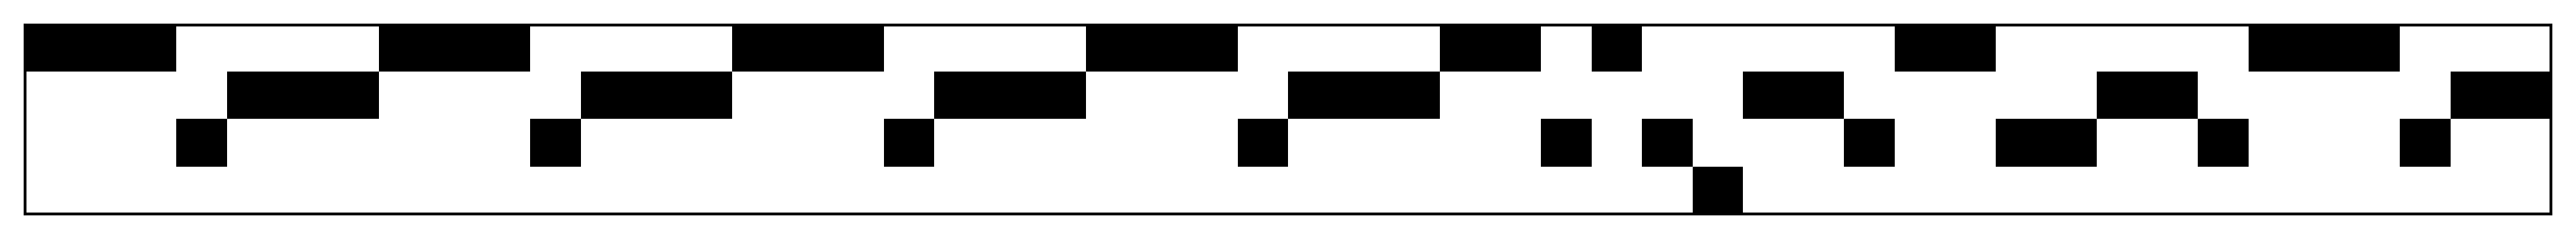

In [2]:
h5 = h5py.File("../paper/h5_files/Athaliana.h5", "r")
fig, ax = plt.subplots(1, 1, figsize=(13, 1), dpi=350)
ax.imshow((1 - h5["data/X"][0][:50].T).astype(float), aspect="auto", cmap='gray', interpolation='none')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.show()

The image below shows a subsequence of *Oryza sativa*. ATAC-seq predictions of the combined model are shown.

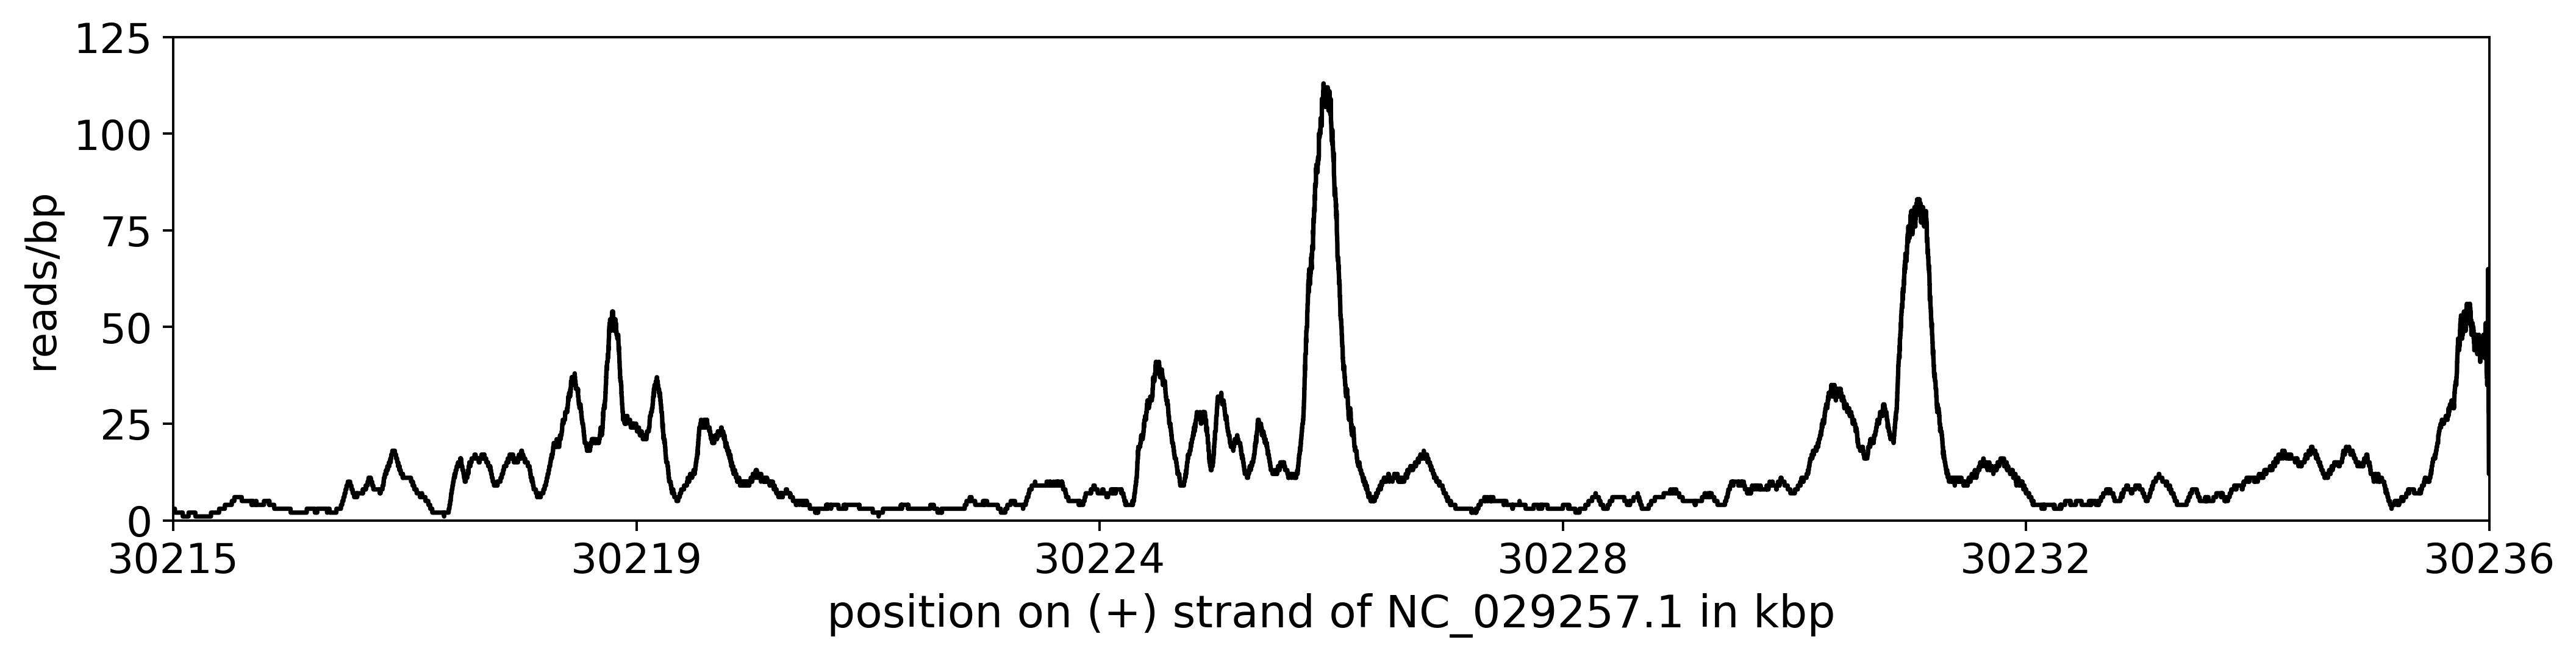

In [3]:
h5_file = h5py.File("../paper/h5_files/Osativa_predictions.h5", "r")
i = 5461
start = 0
end = 21384
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(14, 3.), dpi=350)
se = h5_file['data/start_ends'][i]
offset = h5_file['data/start_ends'][i][0] + start
chrom = h5_file['data/seqids'][i]
pred_cov = np.array(h5_file["prediction/predictions"][i][:,0])
ax.plot(pred_cov, c="black")
ax.set_xlim([start,end])
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim([0,125])
ax.set_ylabel("reads/bp", size=14)

at = [x * (end - start) for x in [0, .2, .4, .60, .8, 1]]
ax.set_xticks(at)
if se[1] - se[0] > 0:
    sign = '+'
    xticklabs = [(offset + x)/ 10**3 for x in at]
else:
    sign = '-'
    xticklabs = [(offset - x)/ 10**3 for x in at]
xticklabs = [int(x) for x in xticklabs]

ax.set_xticklabels(xticklabs, size=14)
ax.set_xlabel('position on ({}) strand of {} in kbp'.format(sign, chrom.decode()), size=15)

plt.show()

## 2. Model Pearson's correlation (Fig. 2)
The species order below corresponds to the order of species given by the NCBI's taxonomy common tree application. The Pearson's correlation per species and model are plotted. The heatmap is divided into ATAC-seq (first block) and ChIP-seq (second block).

In [4]:
species = ["Bnatans", "Creinhardtii", "Mpolymorpha", "Spolyrhiza", "Enindensis", "Othomaeum", "Bdistachyon", "Zmays",
           "Sitalica", "Obrachyantha", "Osativa", "Sindicum", "Slycopersicum", "Mtruncatula", "Gmax", "Pbretschneideri",
           "Ppersica", "Mdomestica", "Boleracea", "Brapa", "Bnapus", "Athaliana"]  # order of taxonomy tree

In [5]:
def get_test_metrics(prefixes, dset, order, input_dir):
    all_test_metrics = []
    for i, prefix in enumerate(prefixes):
        file_path = os.path.join(input_dir, f"{prefix}_test_metrics.log")
        header = np.loadtxt(file_path, max_rows=1, dtype=str)
        idx = np.where(header == f"{dset}_avg_val_accuracy")[0]
        if len(idx) == 0:
            continue
        metrics = np.loadtxt(file_path, skiprows=1, usecols=idx)
        labels = np.loadtxt(file_path, skiprows=1, usecols=0, dtype=str)
        
        # reorder the test metrics to the order of the labels in 'order'
        test_metrics = []
        for species in order:
            if species in labels:
                idx = np.where(labels==species)[0]
                test_metrics.append(metrics[idx])
            else:
                test_metrics.append(np.array([np.nan]))
        all_test_metrics.append(np.concatenate(test_metrics))
    return np.stack(all_test_metrics, axis=-1)

### Load the data

In [6]:
atac_data = get_test_metrics(["U_net_rep3", "Hybrid_rep2", "BiHybrid_rep1", "BiHybrid_02_rep1", "BiHybrid_03.1_rep2",
                              "BiHybrid_03.2_rep2","BiHybrid_03.1_rep2_filtered", "BiHybrid_04_rep3", "Combined_rep3"],
                             "atacseq", species, "results")

In [7]:
chip_data = get_test_metrics(["BiHybrid_05_rep1", "Combined_rep3"], "h3k4me3", species, "results")

In [8]:
total_data = np.concatenate([atac_data, chip_data], axis=1)

In [9]:
models = ["U-Net", "Hybrid", "BiHybrid", "BiHybrid_02", "BiHybrid_03.1","BiHybrid_03.2",
          "BiHybrid_03.1*", "BiHybrid_04*", "Combined*", "BiHybrid_05*", "Combined*"]

In [10]:
def plot_test_metrics(data, cmap, xlabels, ylabels, figsize=(14, 10), dpi=100, yaxis=True, square=True):
    fig, ax = plt.subplots(1, sharex=True, figsize=figsize, dpi=dpi)
    cmap = copy.copy(mpl.colormaps[cmap])
    cmap.set_bad(color="silver")  # NaN values are represented by siver/grey
    im = sns.heatmap(ax=ax, data=data, cmap=cmap, vmin=0., vmax=1., square=square,
                     cbar_kws={"ticks":np.arange(0., 1.1, 0.1), "pad": 0.05, "aspect":20, "shrink": 0.7})
    ax.set_xticks(np.arange(len(xlabels))+0.5, labels=xlabels, fontname="Times New Roman")
    ax.tick_params(axis="x", labelrotation=90, labelsize=16)
    
    if yaxis:
        ax.set_yticks(np.arange(len(ylabels))+0.5, labels=ylabels, fontname="Times New Roman")
        ax.tick_params(axis="y", labelrotation=0, labelsize=16)
    else:
        ax.get_yaxis().set_visible(False)
    
    b, t = plt.ylim()
    ax.vlines(x = 9, ymin = b, ymax = t, colors = 'white', lw = 10)
    
    # cbar
    cbar = im.collections[0].colorbar
    cbar.ax.set_ylabel("Pearson's r",rotation=-90, va="bottom", size=17, fontname="Times New Roman")
    cbar.ax.tick_params(labelsize=14, color="black", direction="out", length=5., pad=0.5, width=1.5)
    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_family("Times New Roman")

    plt.setp(ax.spines.values(), color=None)
    plt.show()

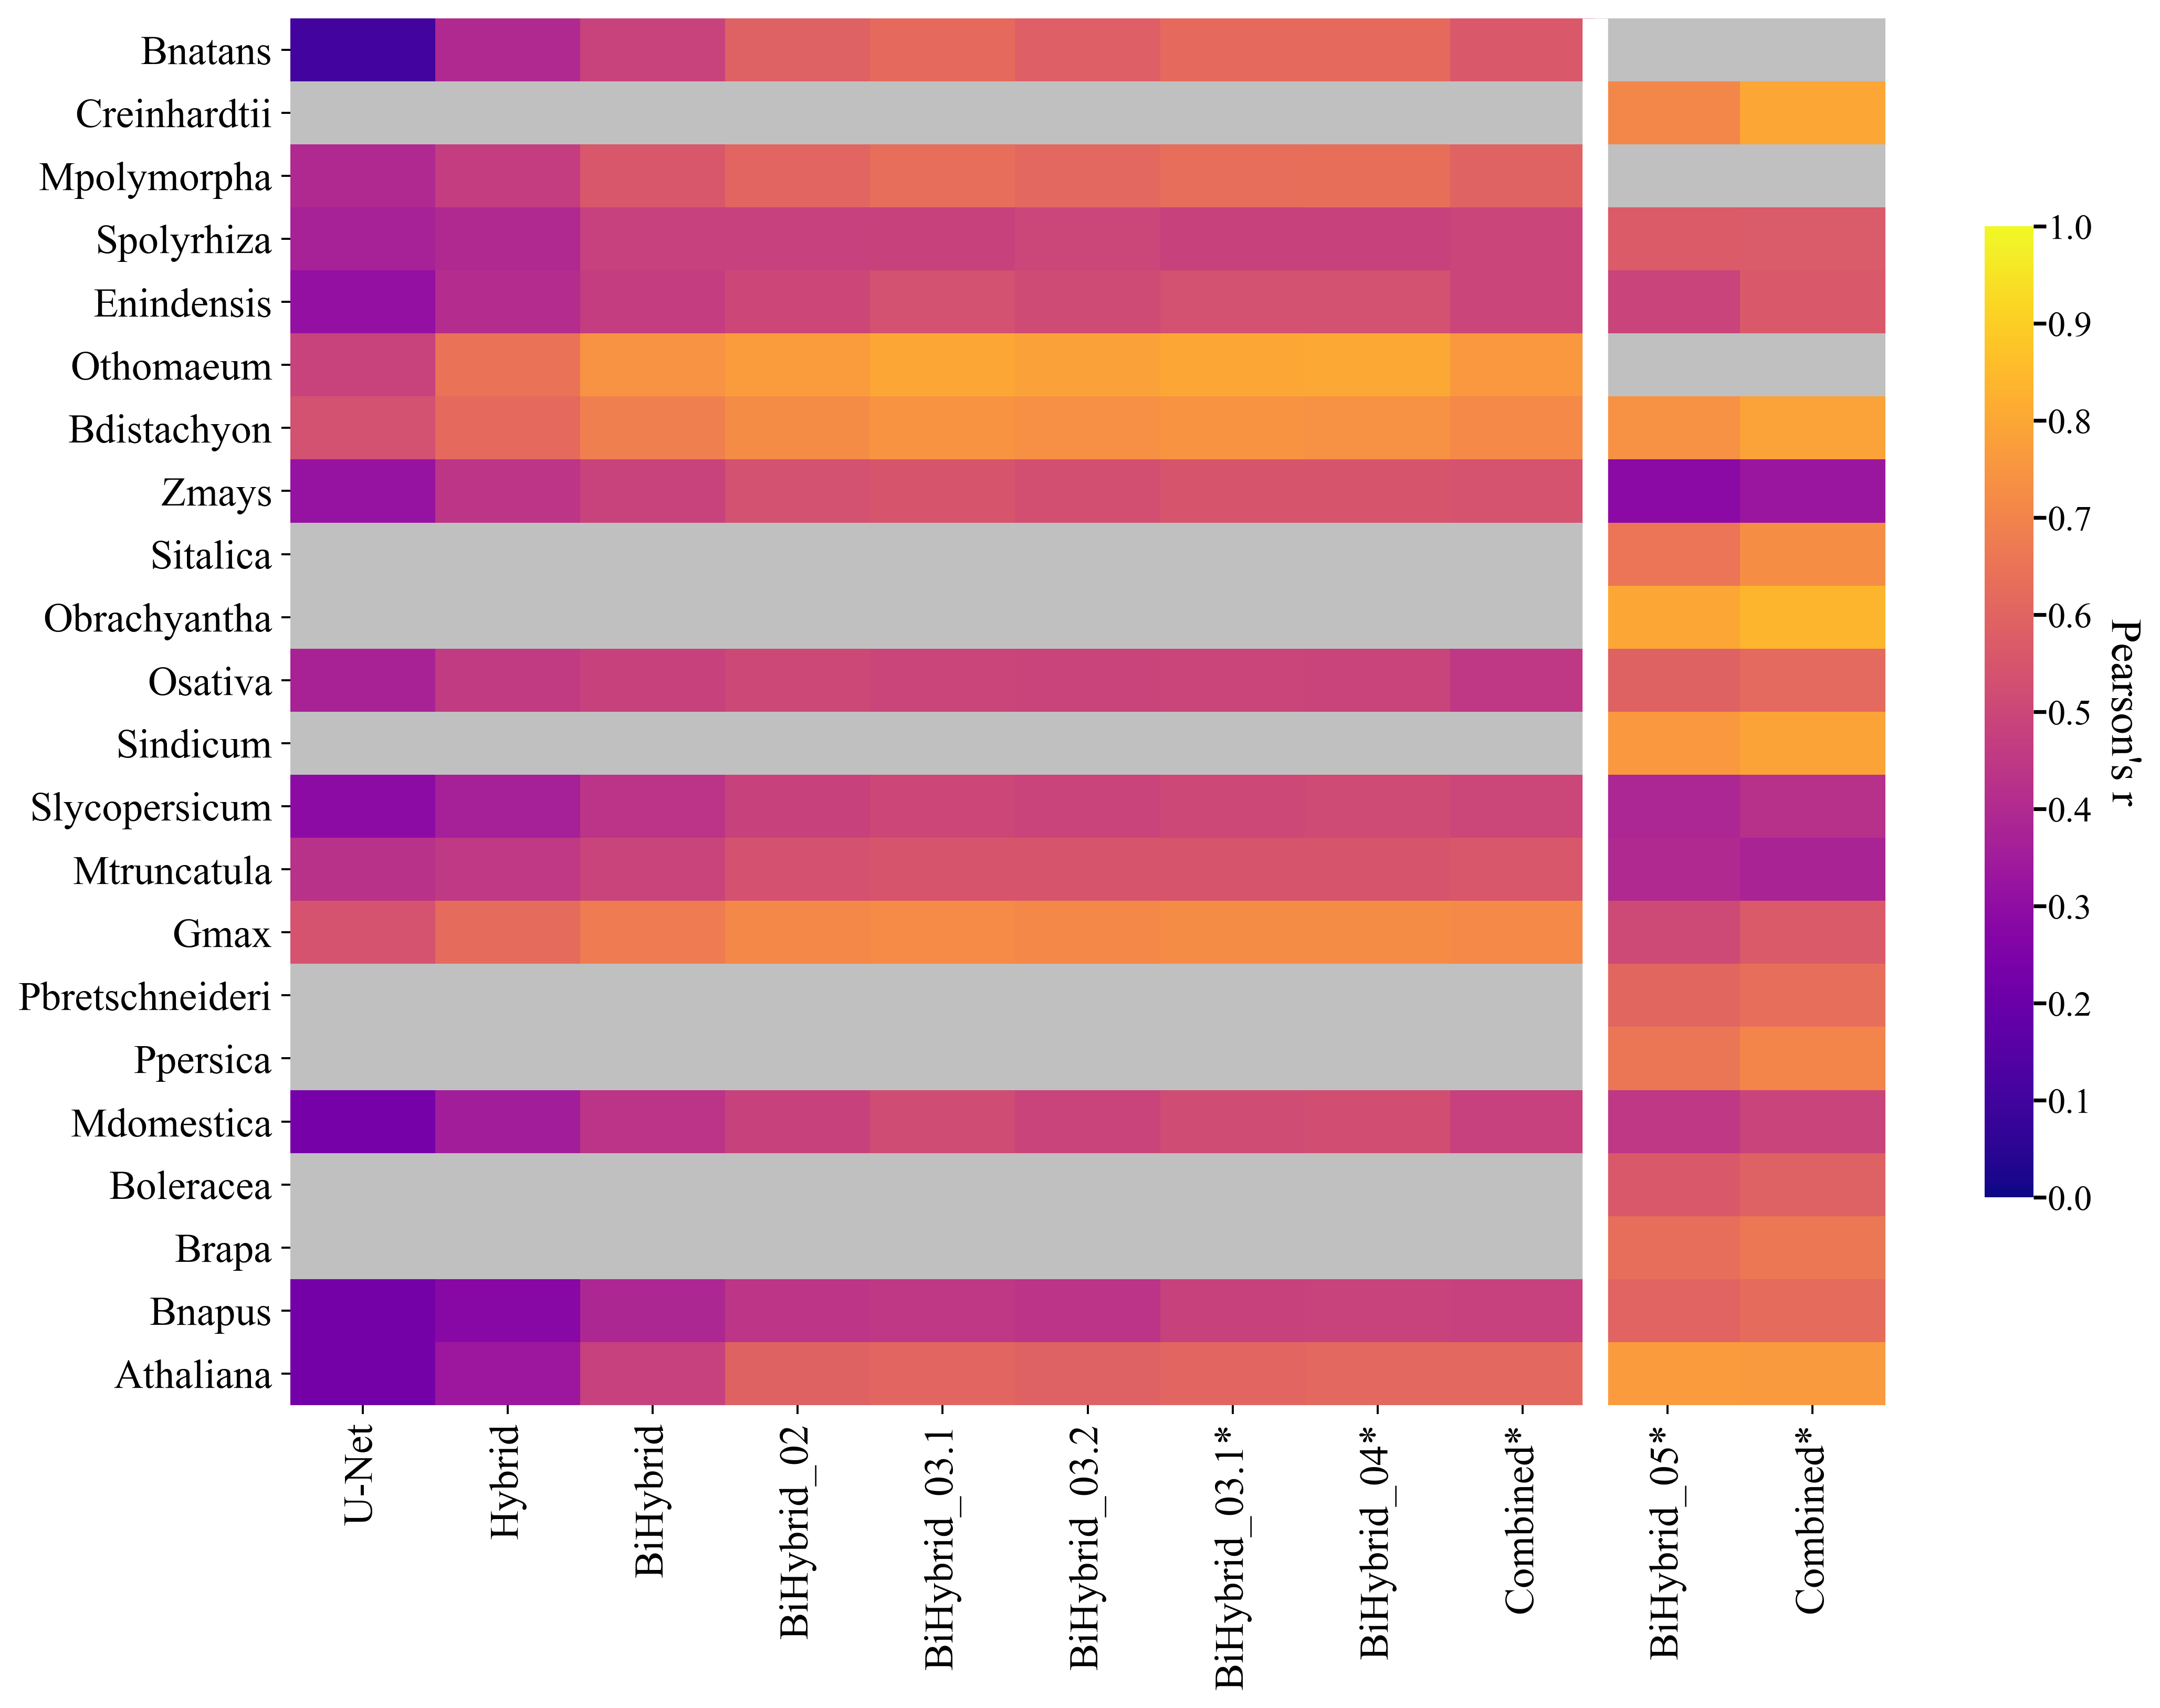

In [11]:
# not square
plot_test_metrics(total_data, "plasma", models, species, dpi=350, square=False)

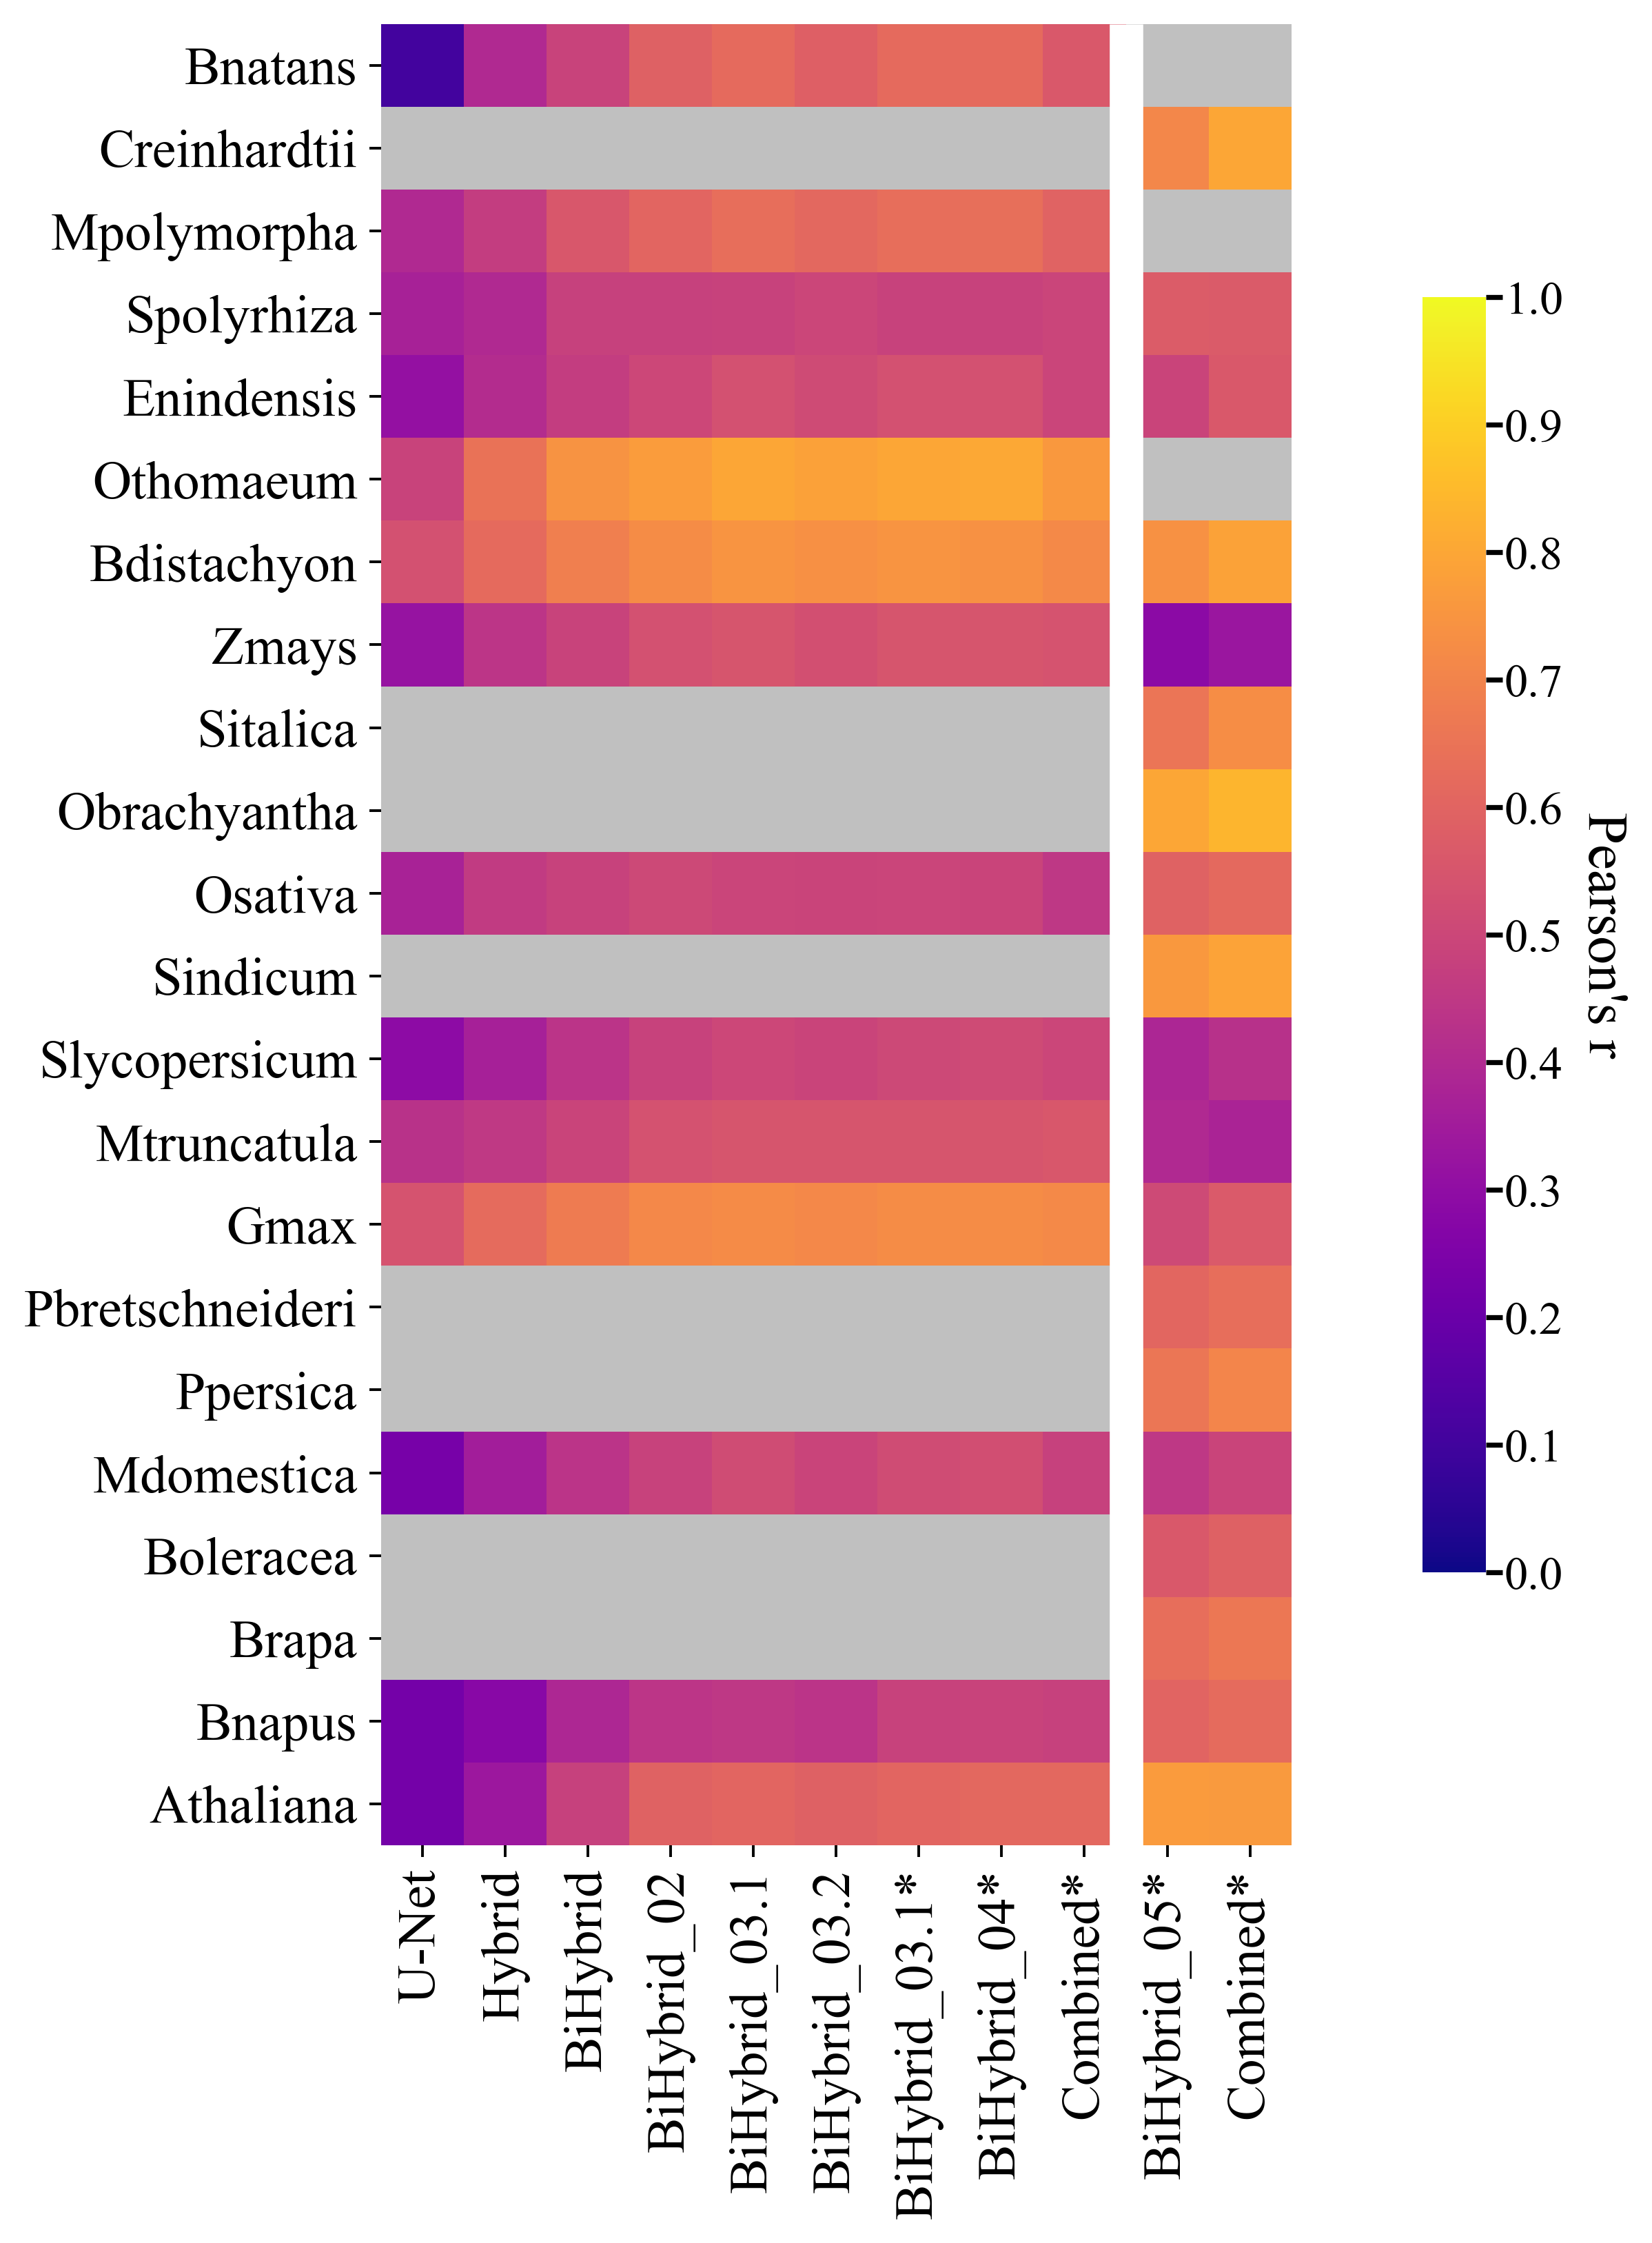

In [12]:
# with y labels
plot_test_metrics(total_data, "plasma", models, species, dpi=350)

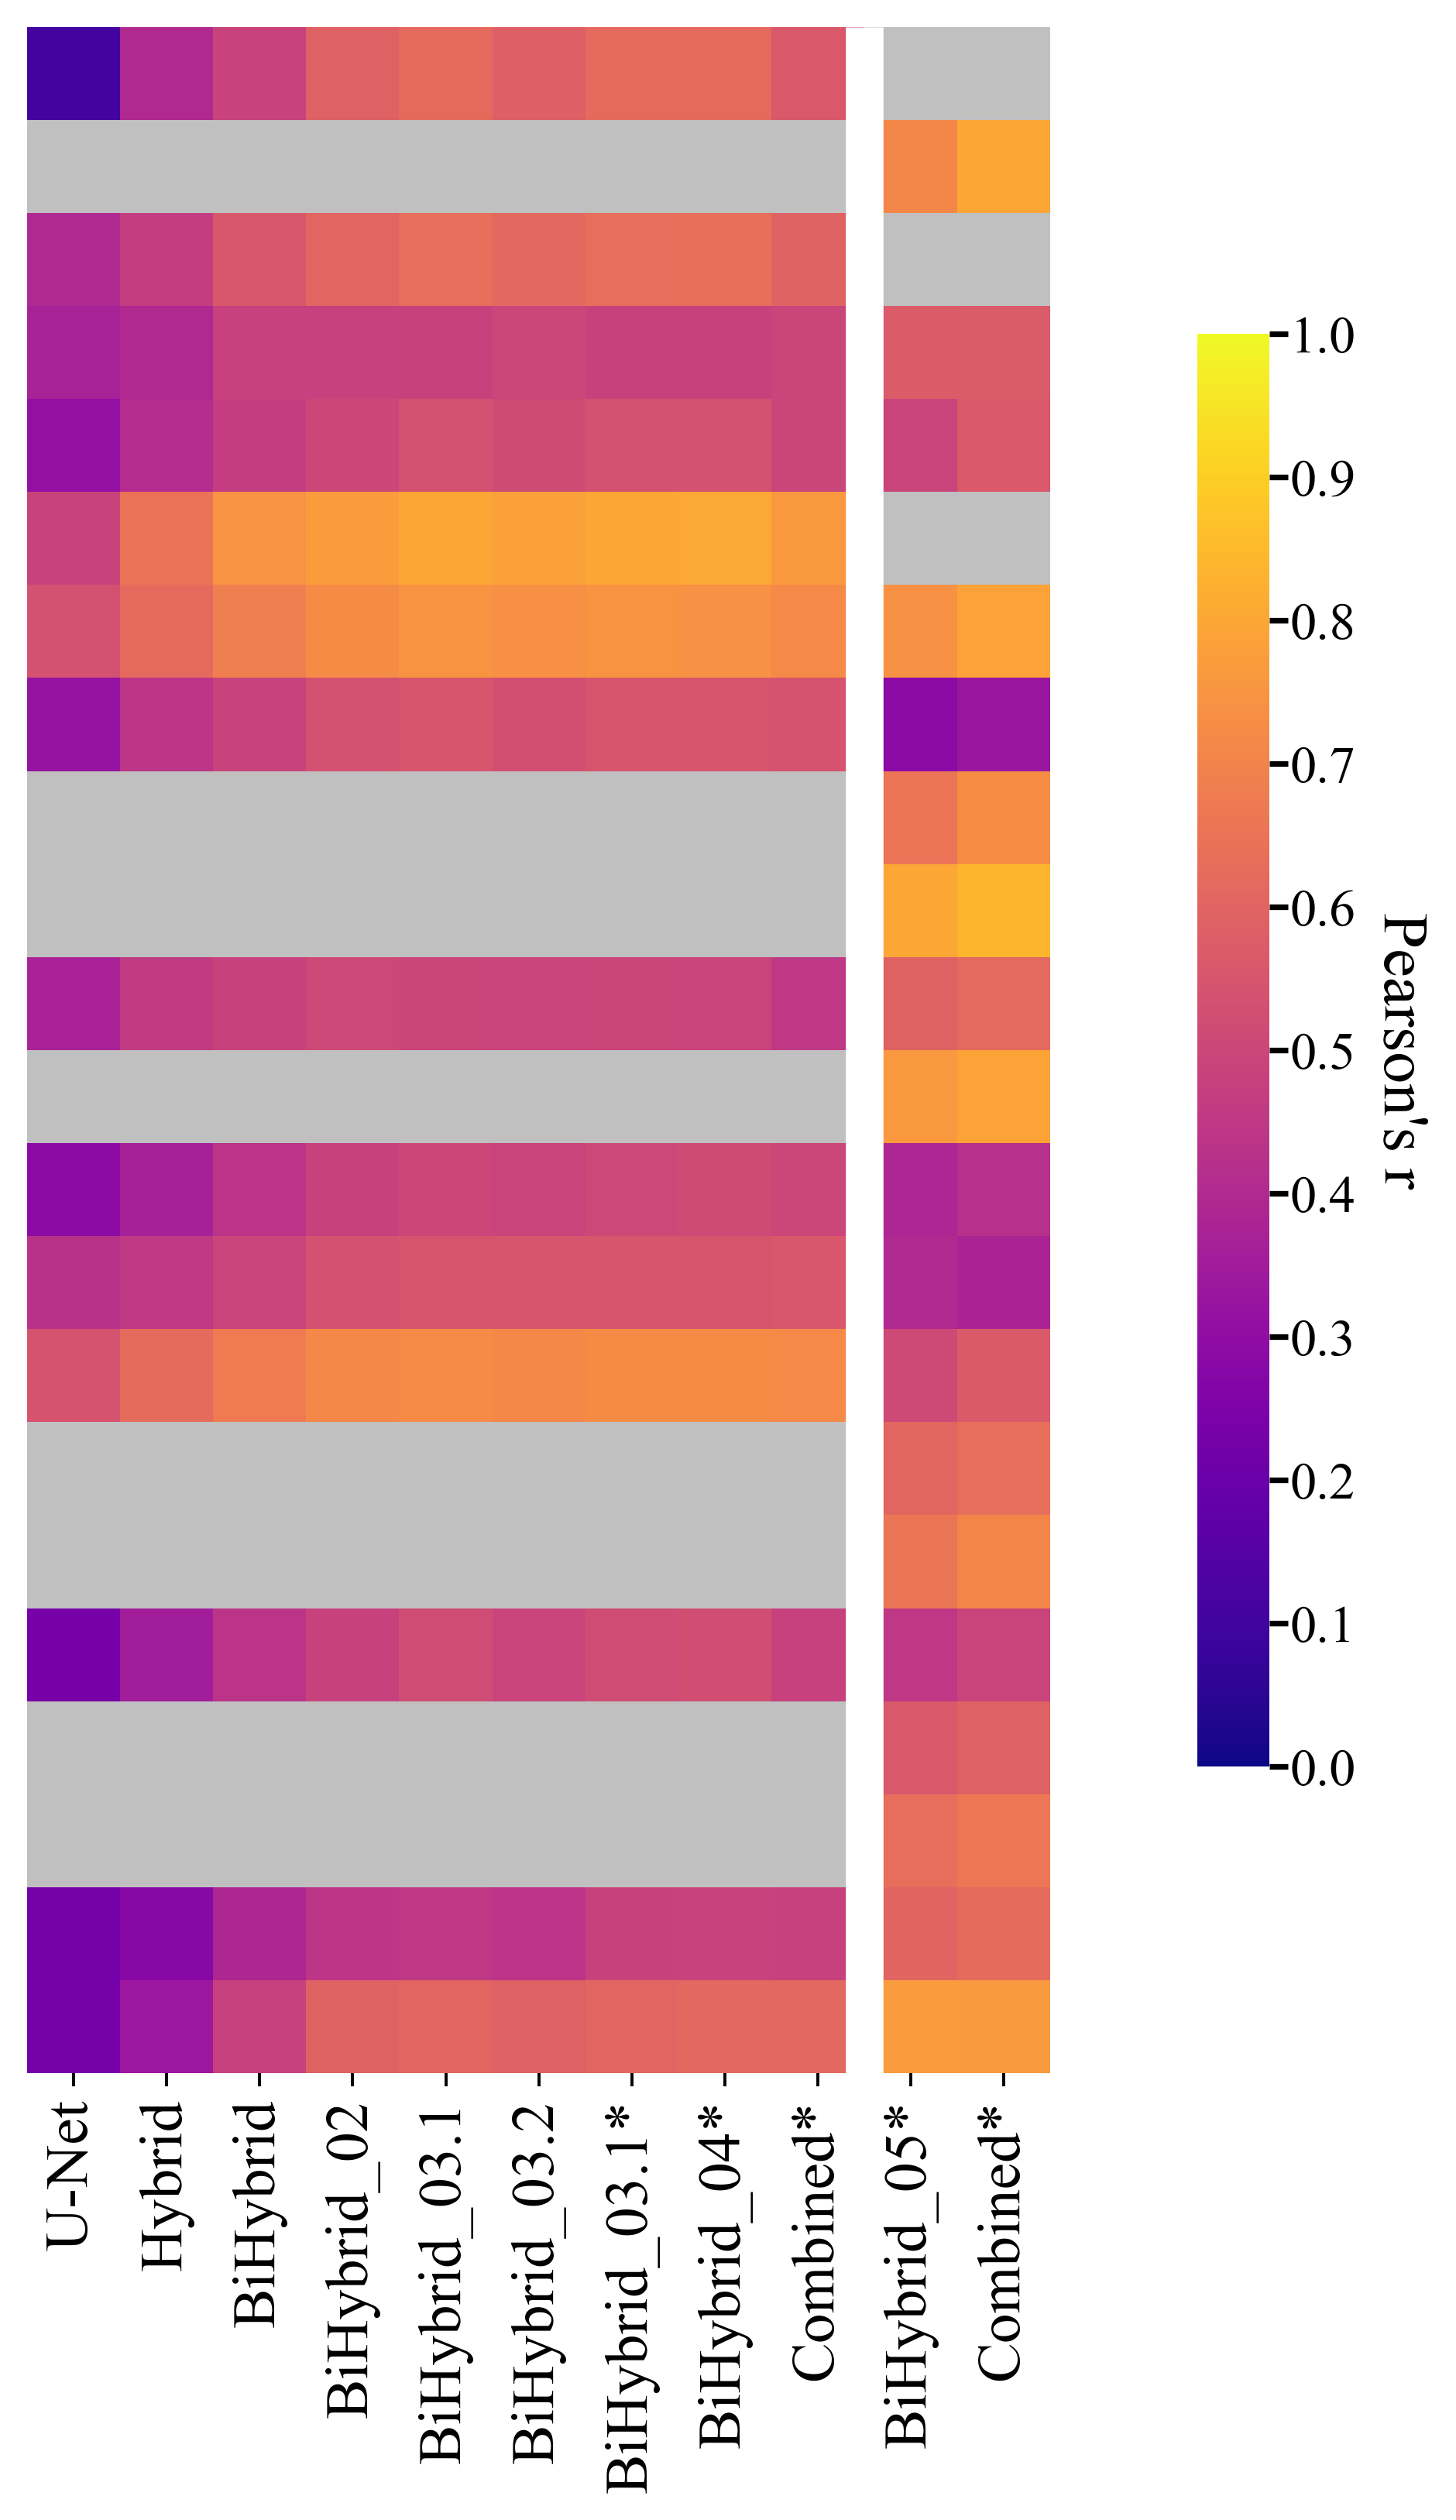

In [13]:
# used for final Figure 1
plot_test_metrics(total_data, "plasma", models, species, dpi=350, yaxis=False)

## 3. In-depth look into predictions (Fig. 4)
Six example regions comparing Predmoter predictions (in blue) to experimental data (target/Y; in black) for the species *A. thaliana* and *O. sativa* in 5’ to 3’ direction are depicted. Three different prediction qualities are shown: "good", "medium" and "bad". The genome annotation was added to the non-prediction h5 files via [GeenuFF](https://github.com/weberlab-hhu/GeenuFF) and [Helixer](https://github.com/weberlab-hhu/Helixer).

In [14]:
def plot_selected(i, f, pred, start, end, ylim, fsize=18, figsize=(14, 8.), as_int=True,
                  c_augline='gainsboro', dpi=100, show_legend=False):
    
    print(i)
    se = f['data/start_ends'][i]
    offset = f['data/start_ends'][i][0] + start
    chrom = f['data/seqids'][i]
    print(chrom, se)
    
    datasets = [dset.decode() for dset in pred["prediction/datasets"][:]]
    
    if "alternative" in f.keys():
        subplots = len(datasets) + 1  # reference annotation
        height_ratios = [1.2]*len(datasets) + [0.5]
        
    else:
        subplots = len(datasets)
        height_ratios = [1.2]*len(datasets)
        
    
    fig, axs = plt.subplots(subplots, 1, sharex=True, figsize=figsize,
                           gridspec_kw={"height_ratios": height_ratios}, dpi=dpi)
    
    for j, dset in enumerate(datasets):
        print(dset)
        axis_label = "ATAC-seq reads/bp" if dset == "atacseq" else "H3K4me3 reads/bp"
        legend=[]
        if f"{dset}_coverage" in f["evaluation"].keys():
            cov = np.mean(np.array(f[f'evaluation/{dset}_coverage'][i][start:end]), axis=1)
            axs[j].plot(cov, c="black")
            legend.append("target/Y")
            
        pred_cov = np.array(pred["prediction/predictions"][i][:,j][start:end])
        axs[j].plot(pred_cov, c="dodgerblue")
        legend.append("predictions")
        
        axs[j].set_xlim((0, end - start))
        axs[j].tick_params(axis='y', labelsize=fsize-1)
        axs[j].set_ylim(ylim[j])
        axs[j].set_ylabel(axis_label, size=fsize-1)
        if show_legend and j == 0:
            axs[j].legend(legend, fontsize=fsize)
    
    yticks = ['IG', 'UTR', 'CDS', 'Ntrn']
    if "alternative" in f.keys():
        j += 1
        axs[j].imshow(1 - np.array(f[f"alternative/reference/y"][i][start:end].T).astype(float),
                      aspect="auto", cmap='gray', interpolation='none')
        axs[j].set_ylim([-0.5, 3.5])
        axs[j].set_yticks([0,1,2, 3])
        axs[j].set_yticklabels(yticks, size=fsize-1)
        axs[j].set_ylabel("Ref.", size=fsize-1)
    

    at = [x * (end - start) for x in [0, .2, .4, .60, .8, 1]]
    axs[j].set_xticks(at)
    if se[1] - se[0] > 0:
        sign = '+'
        xticklabs = [(offset + x)/ 10**3 for x in at]
    else:
        sign = '-'
        xticklabs = [(offset - x)/ 10**3 for x in at]
    if as_int:
        xticklabs = [int(x) for x in xticklabs]
    else:
        xticklabs = [round(x, 2) for x in xticklabs]
    axs[j].set_xticklabels(xticklabs, size=fsize-1)
    axs[j].set_xlabel('position on ({}) strand of {} in kbp'.format(sign, chrom.decode()), size=fsize)
    
    plt.subplots_adjust(hspace=0.06)
    plt.show()

### _Arabidopsis thaliana_: "good", "medium", and "bad" examples

In [15]:
f = h5py.File("../paper/h5_files/Athaliana.h5", "r")
g = h5py.File("../paper/h5_files/Athaliana_predictions.h5", "r")

5980
b'NC_003074.8' [19373904 19352520]
atacseq
h3k4me3


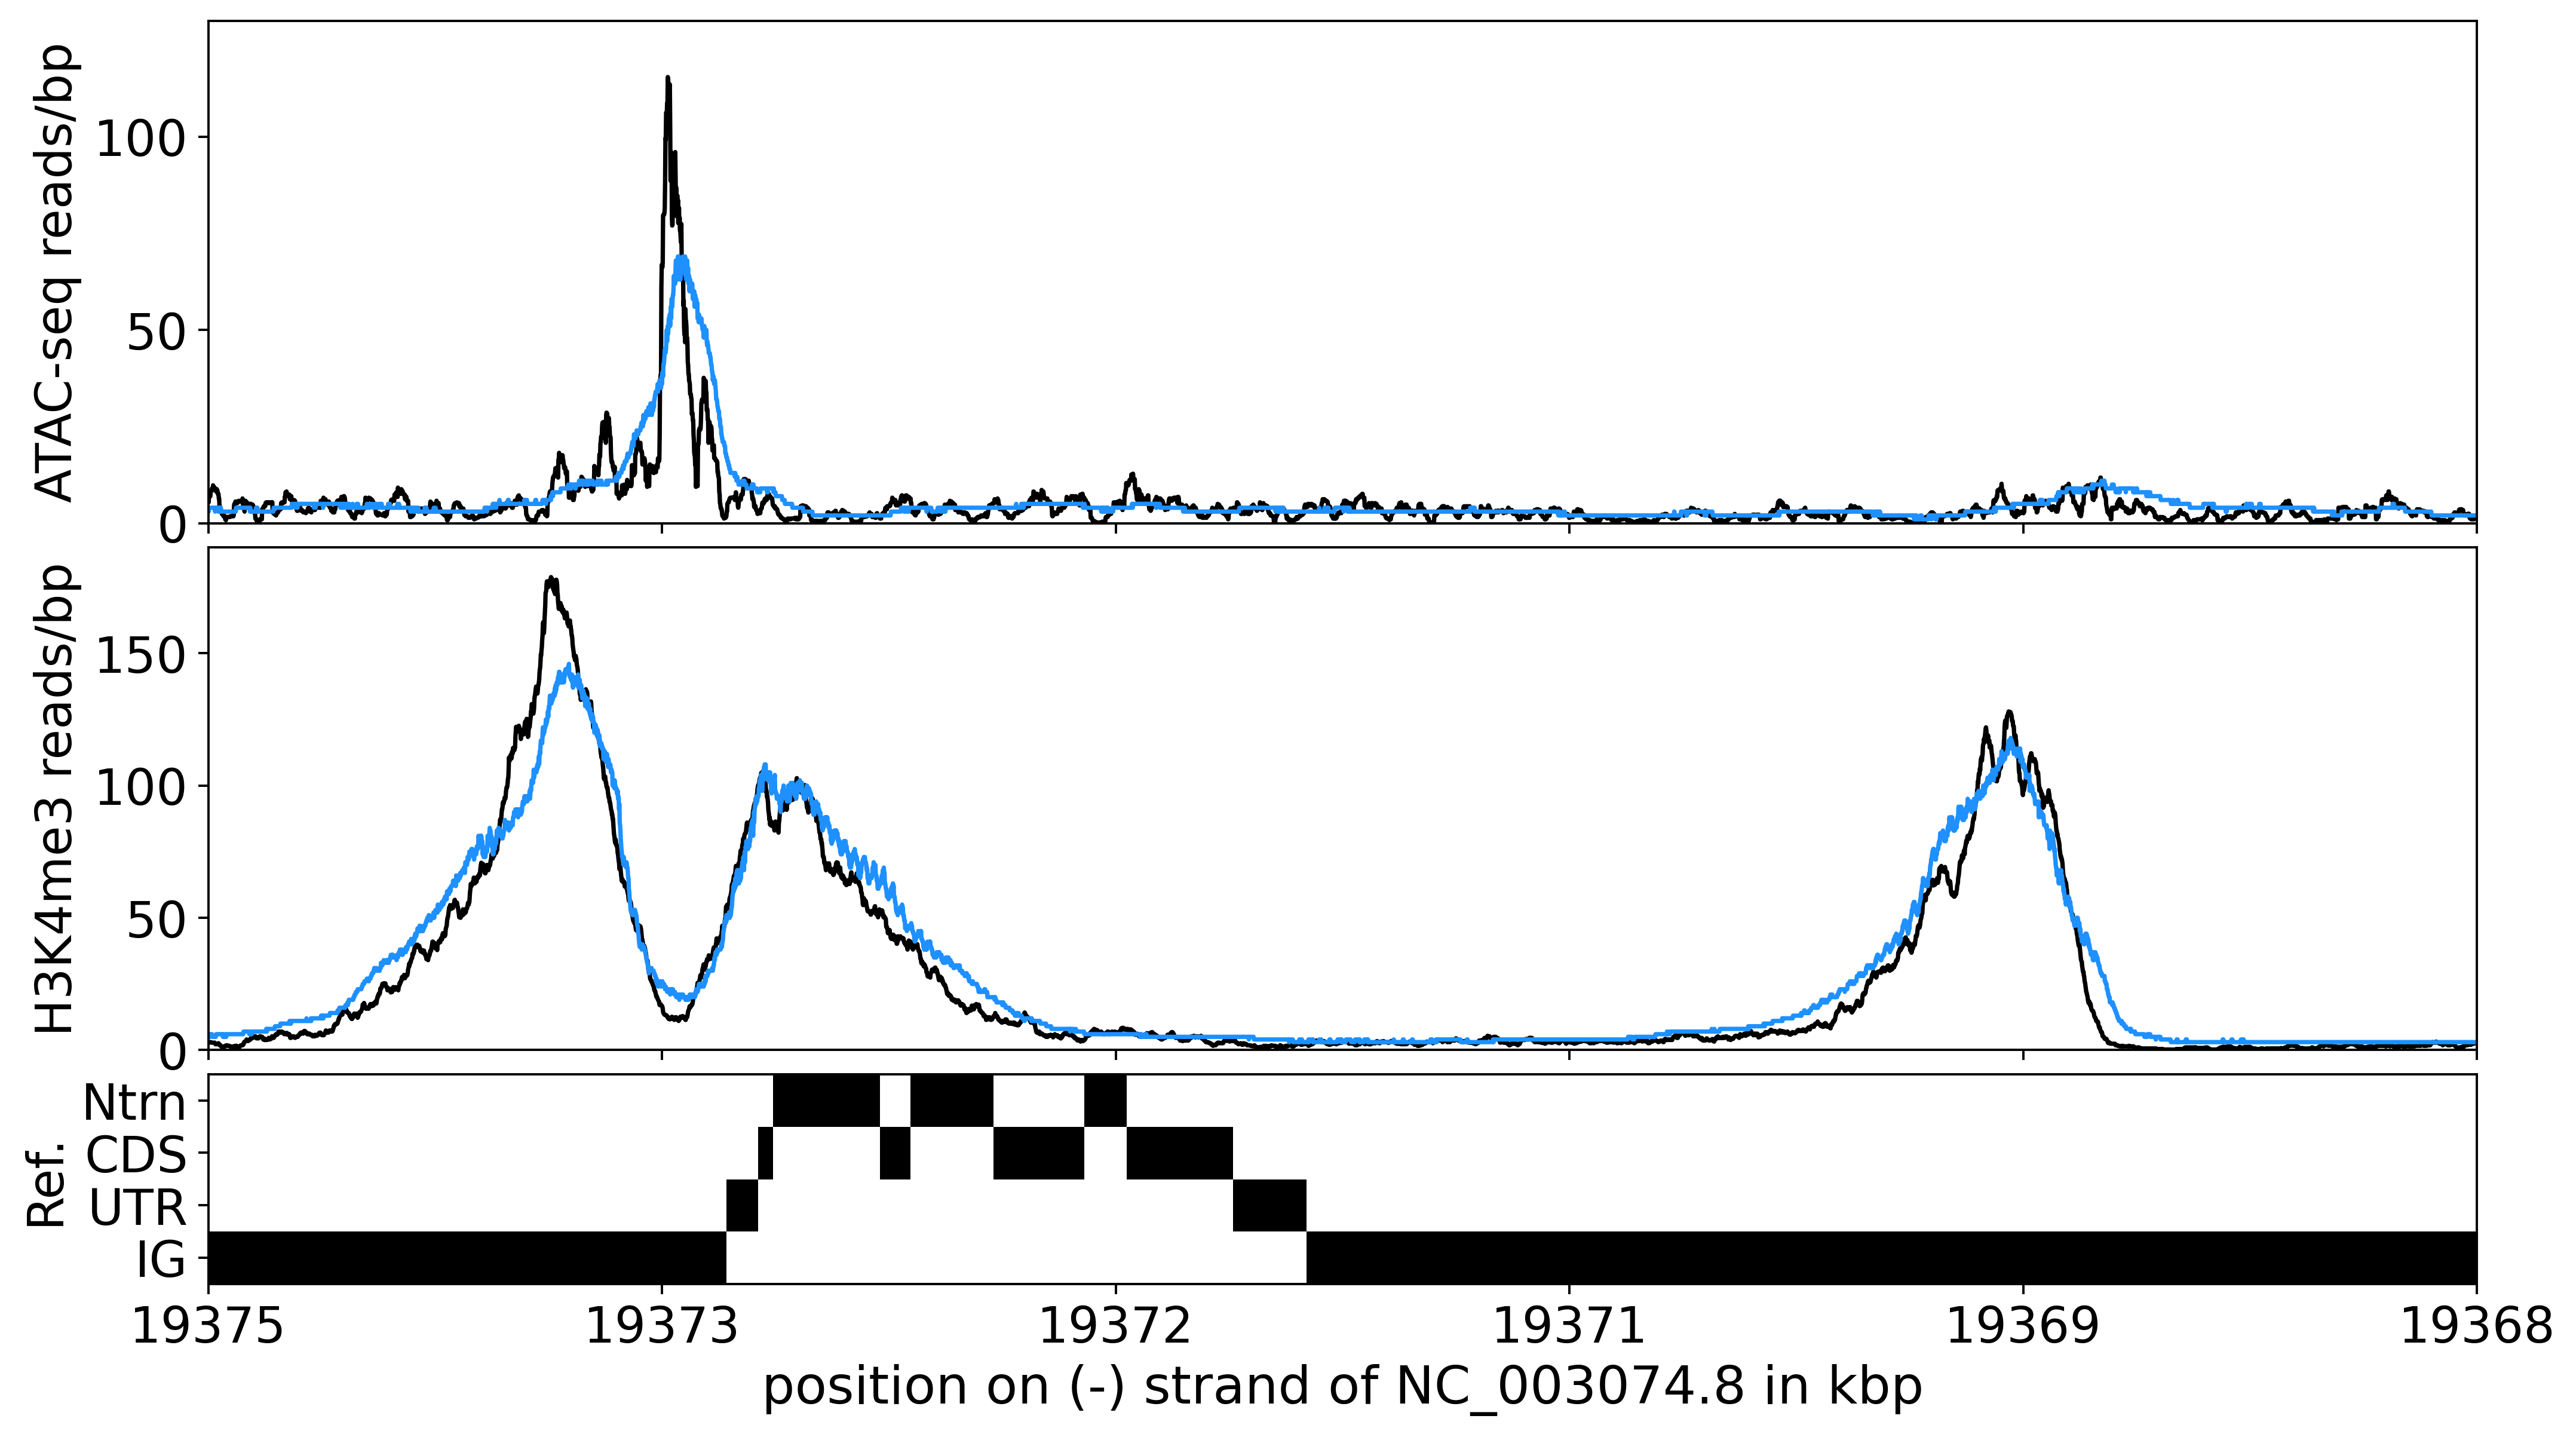

In [16]:
plot_selected(5980, f, g, ylim=[[0, 130], [0, 190]], start=1300, end=8000, dpi=350)

3735
b'NC_003071.7' [19010376 19031760]
atacseq
h3k4me3


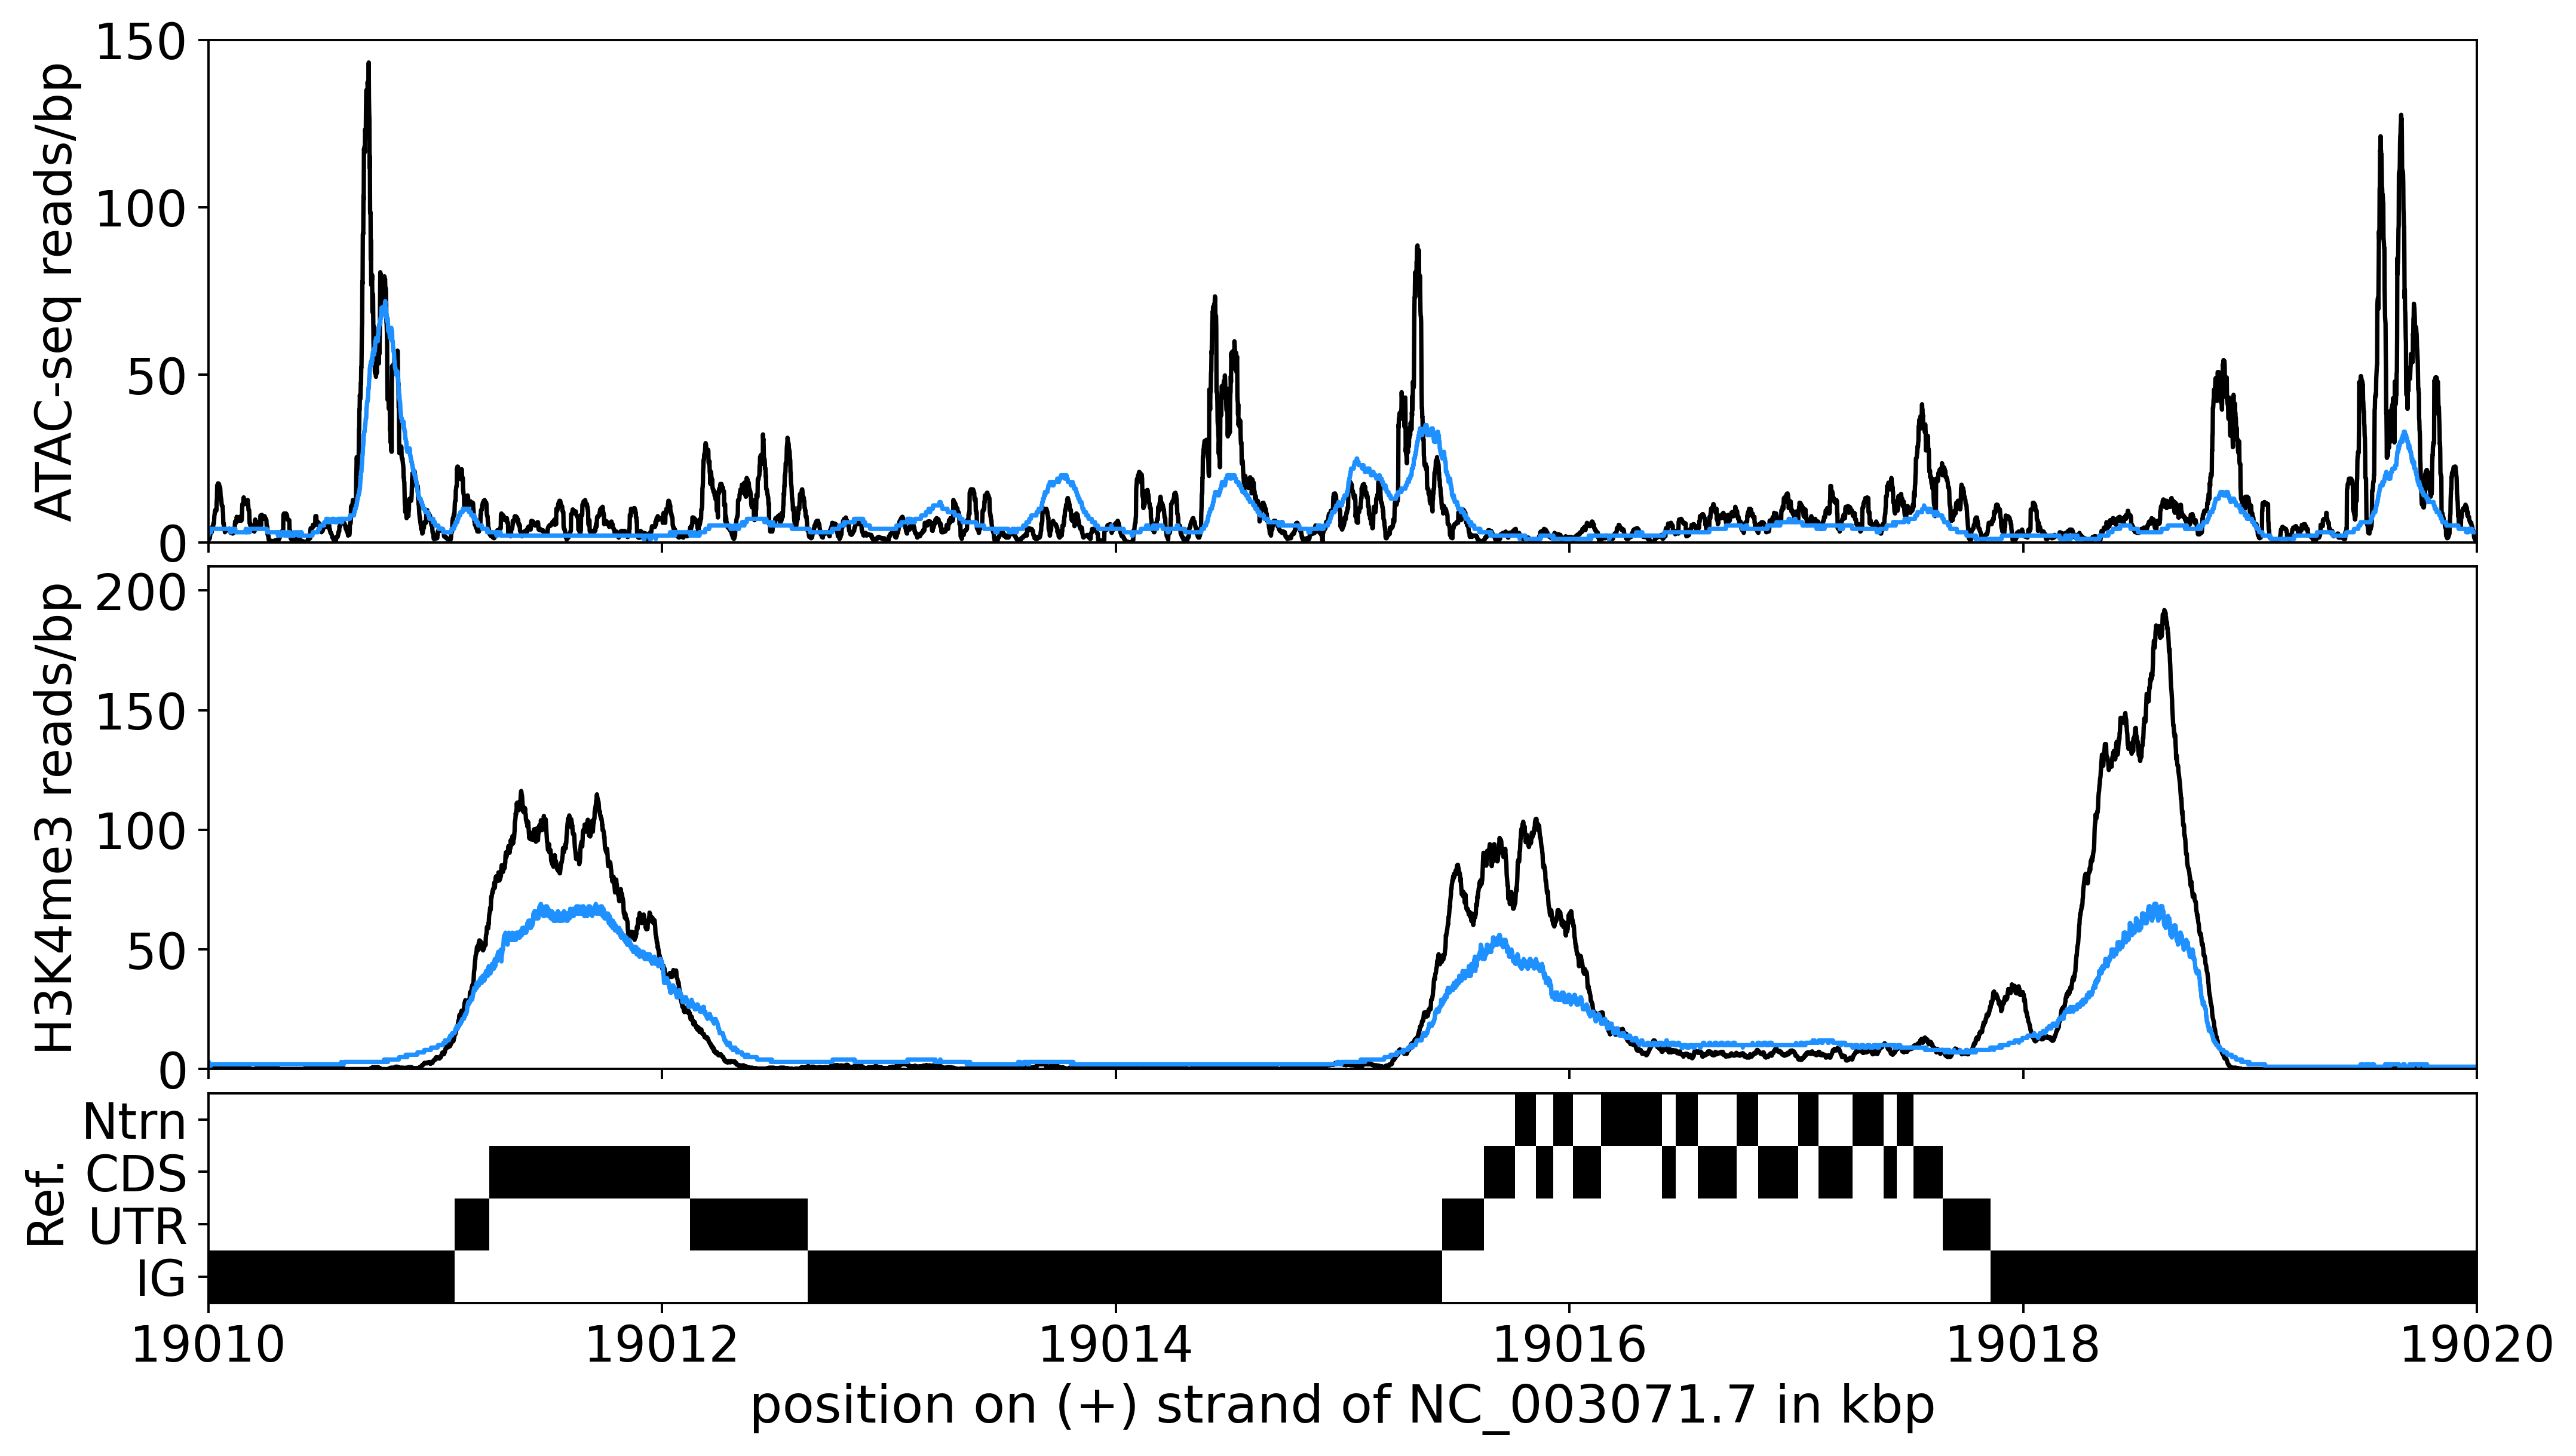

In [17]:
plot_selected(3735, f, g, ylim=[[0, 150], [0, 210]], start=0, end=10000, dpi=350)

13
b'NC_003070.9' [277992 299376]
atacseq
h3k4me3


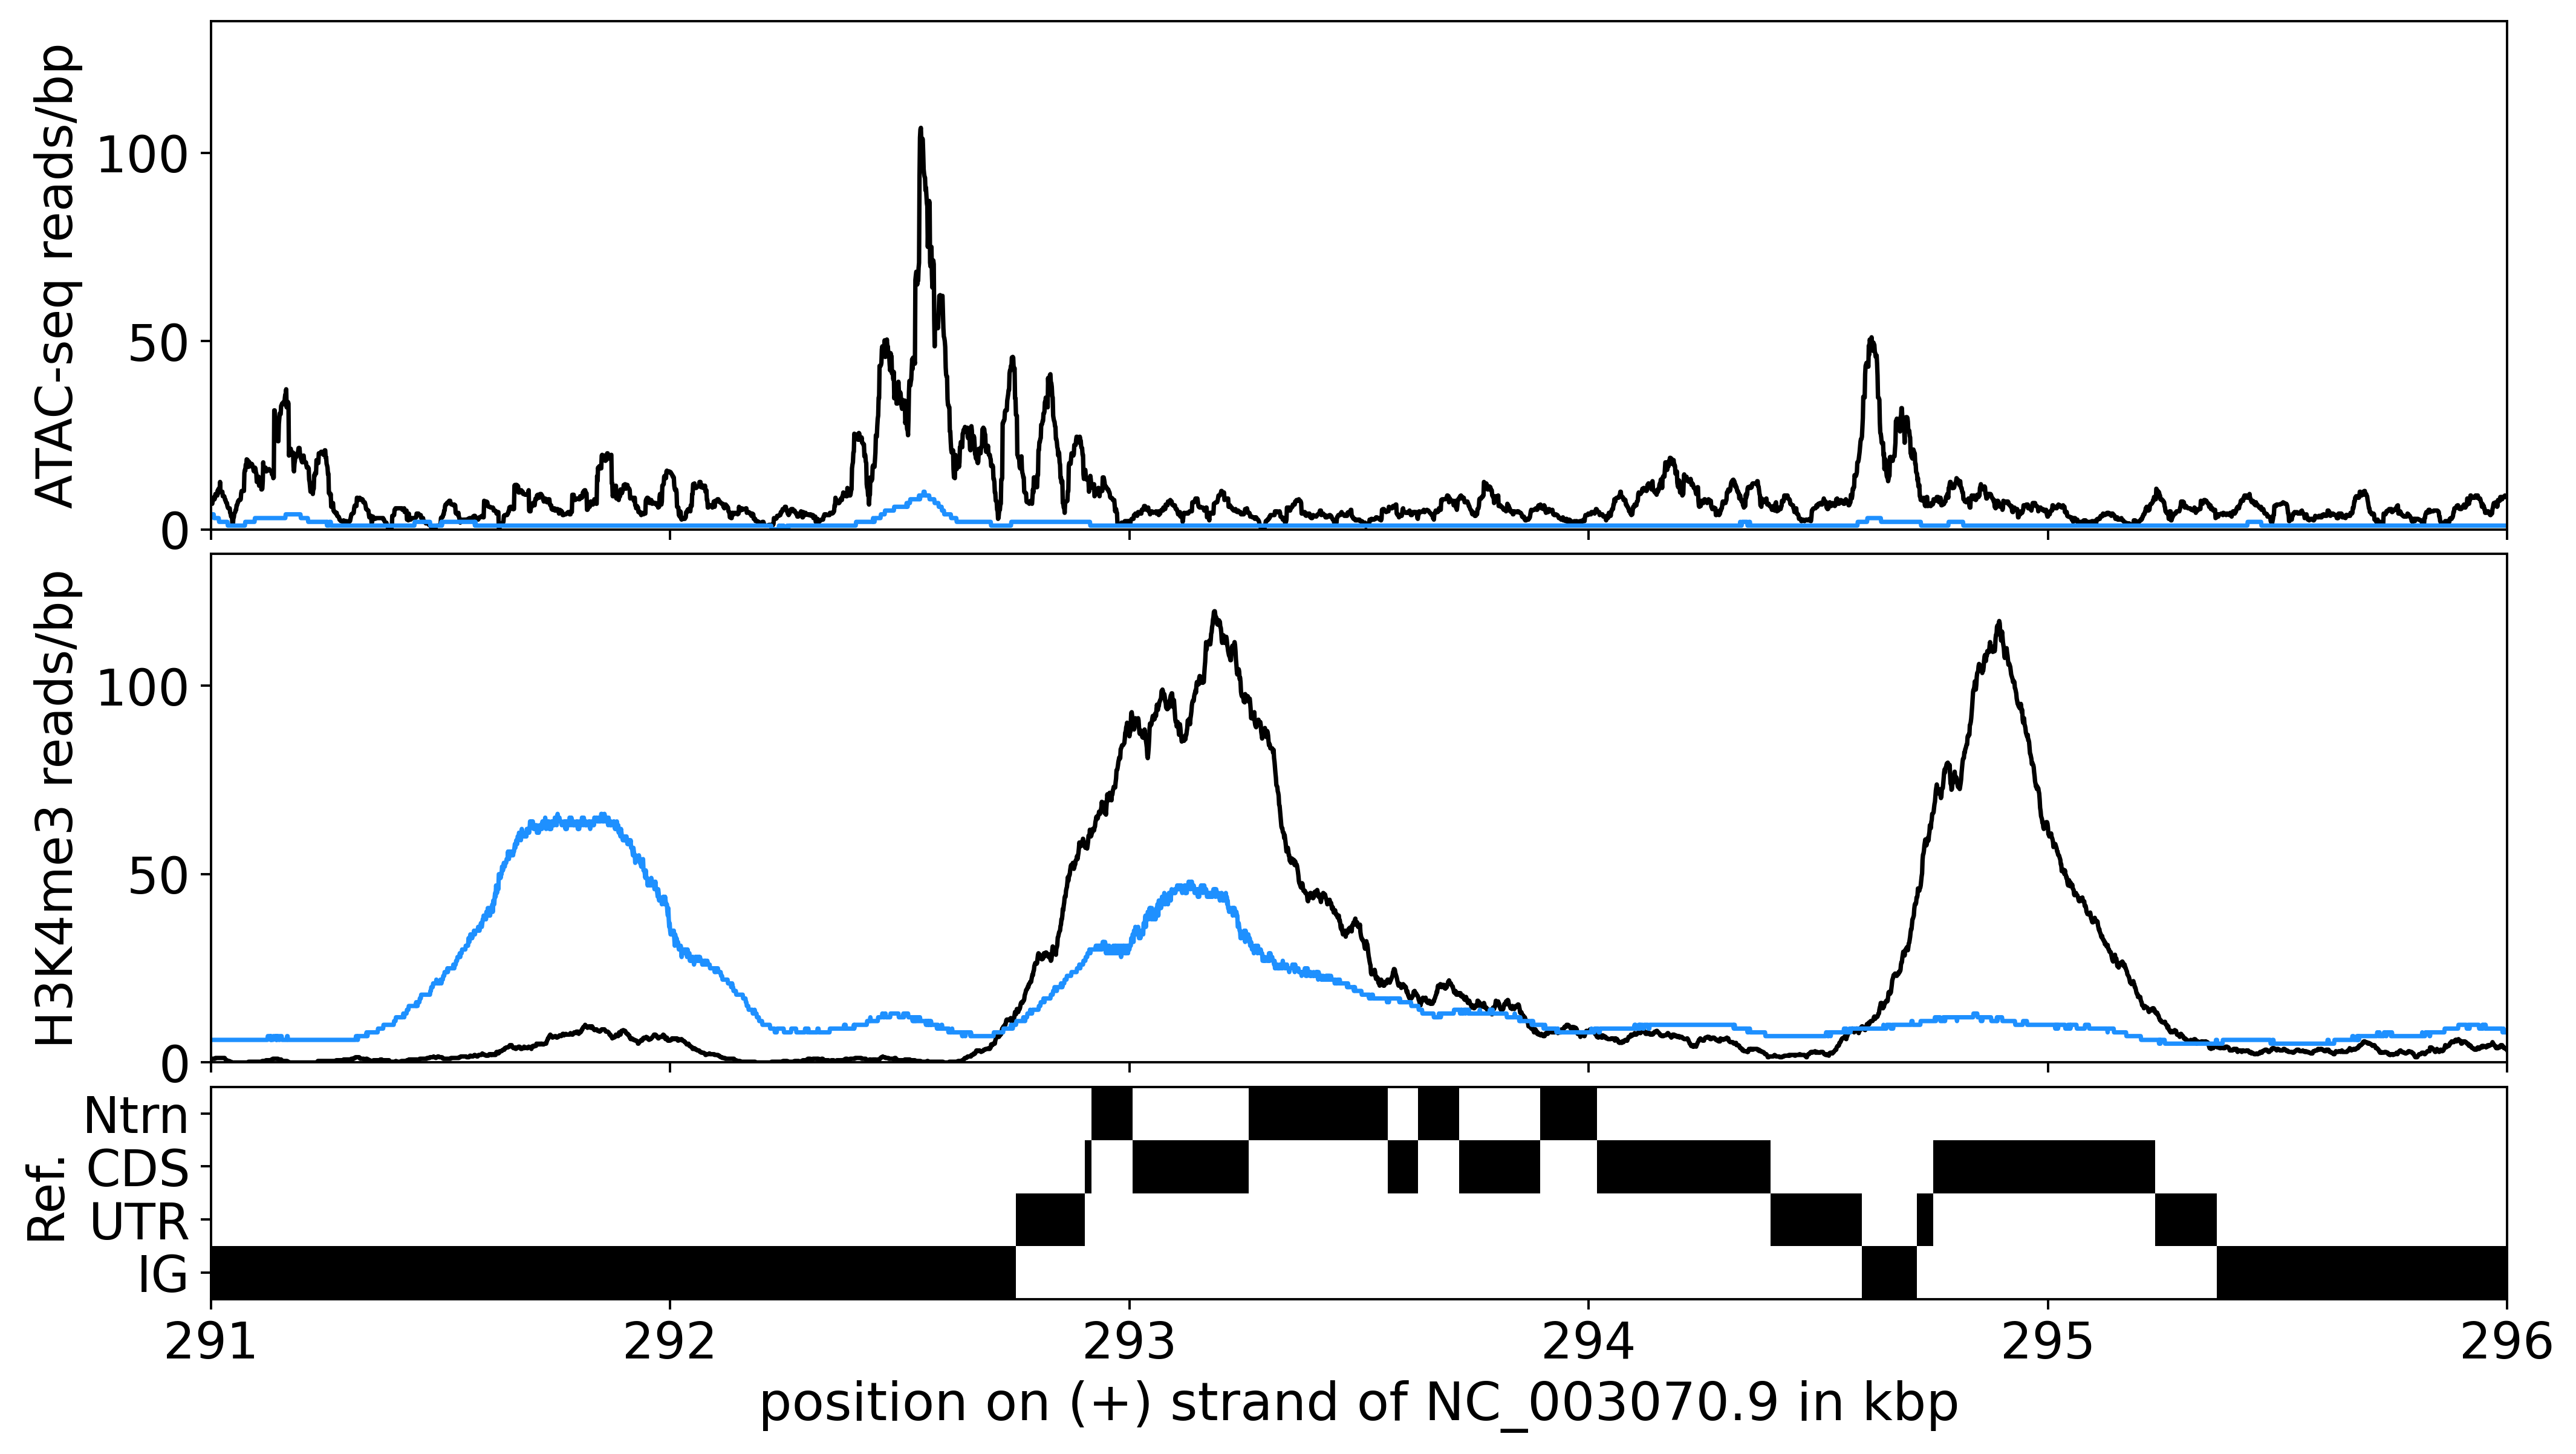

In [18]:
plot_selected(13, f, g, ylim=[[0, 135], [0, 135]], start=13500, end=18500, dpi=350)

### _Oryza sativa_: "good", "medium", and "bad" examples

In [19]:
f = h5py.File("../paper/h5_files/Osativa.h5", "r")
g = h5py.File("../paper/h5_files/Osativa_predictions.h5", "r")

5461
b'NC_029257.1' [30215592 30236976]
atacseq
h3k4me3


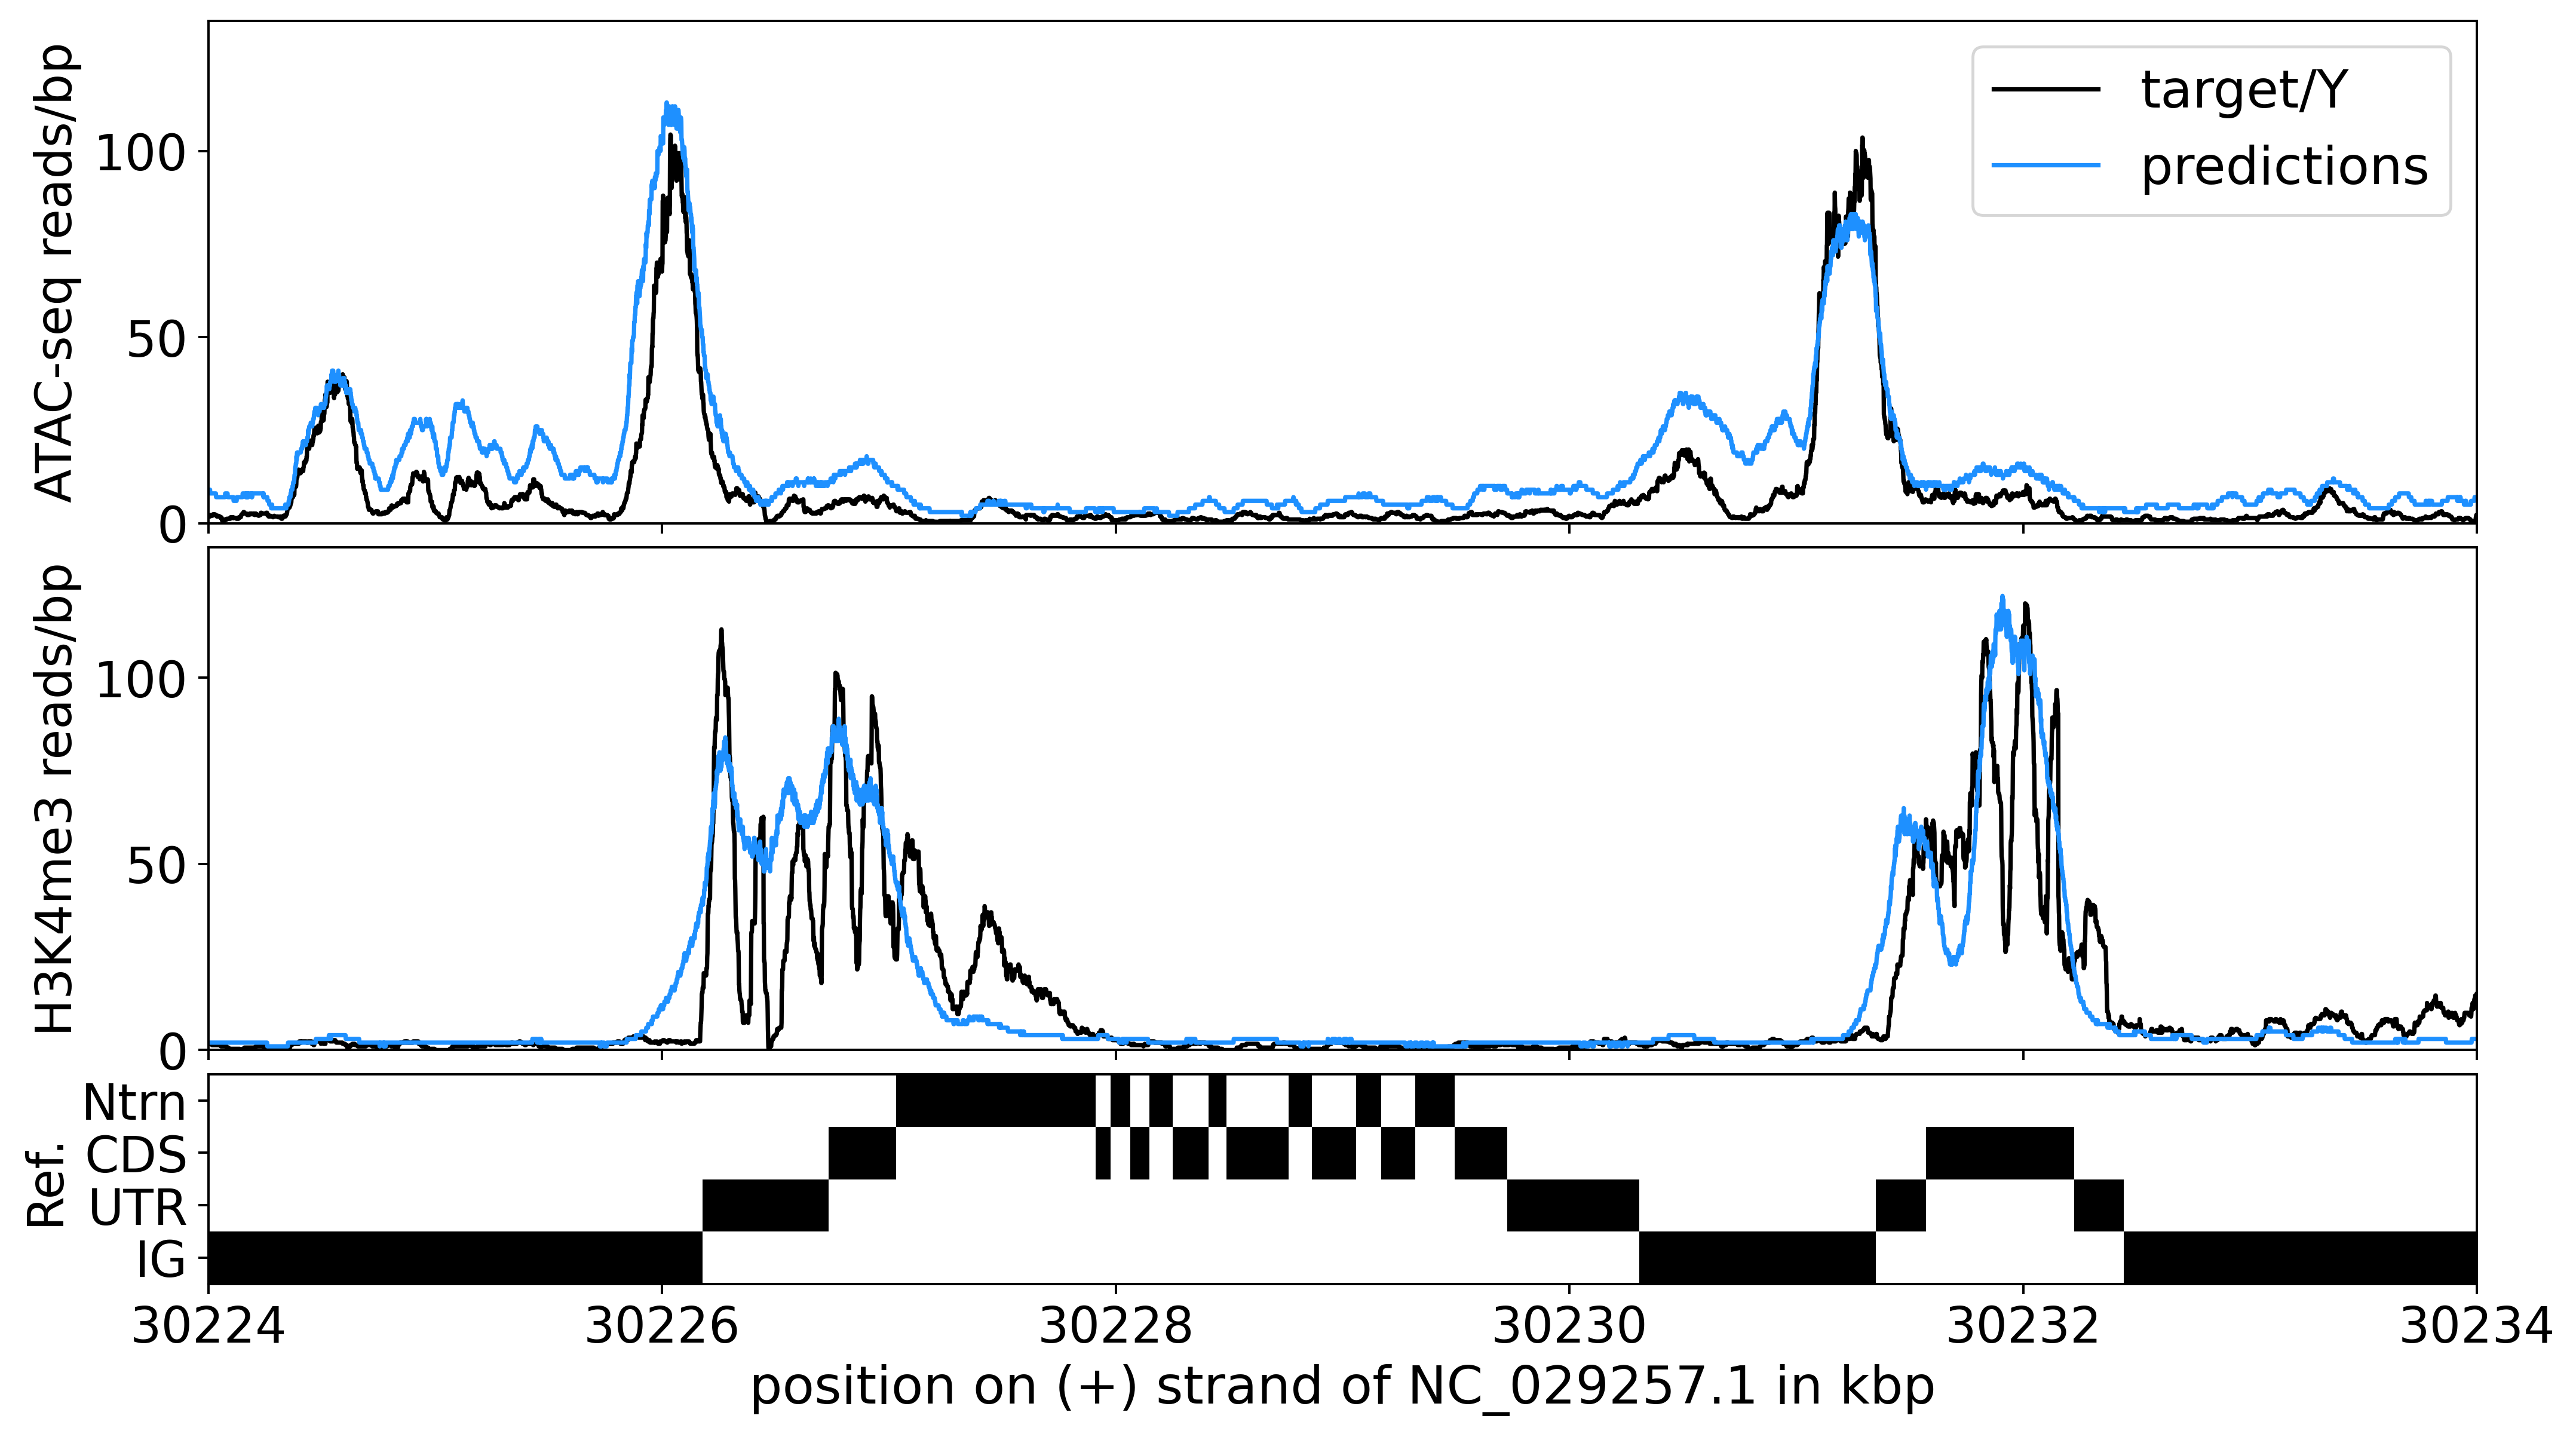

In [20]:
plot_selected(5461, f, g, ylim=[[0, 135], [0, 135]], start=8500, end=19000, dpi=350, show_legend=True)

5957
b'NC_029257.1' [31070952 31049568]
atacseq
h3k4me3


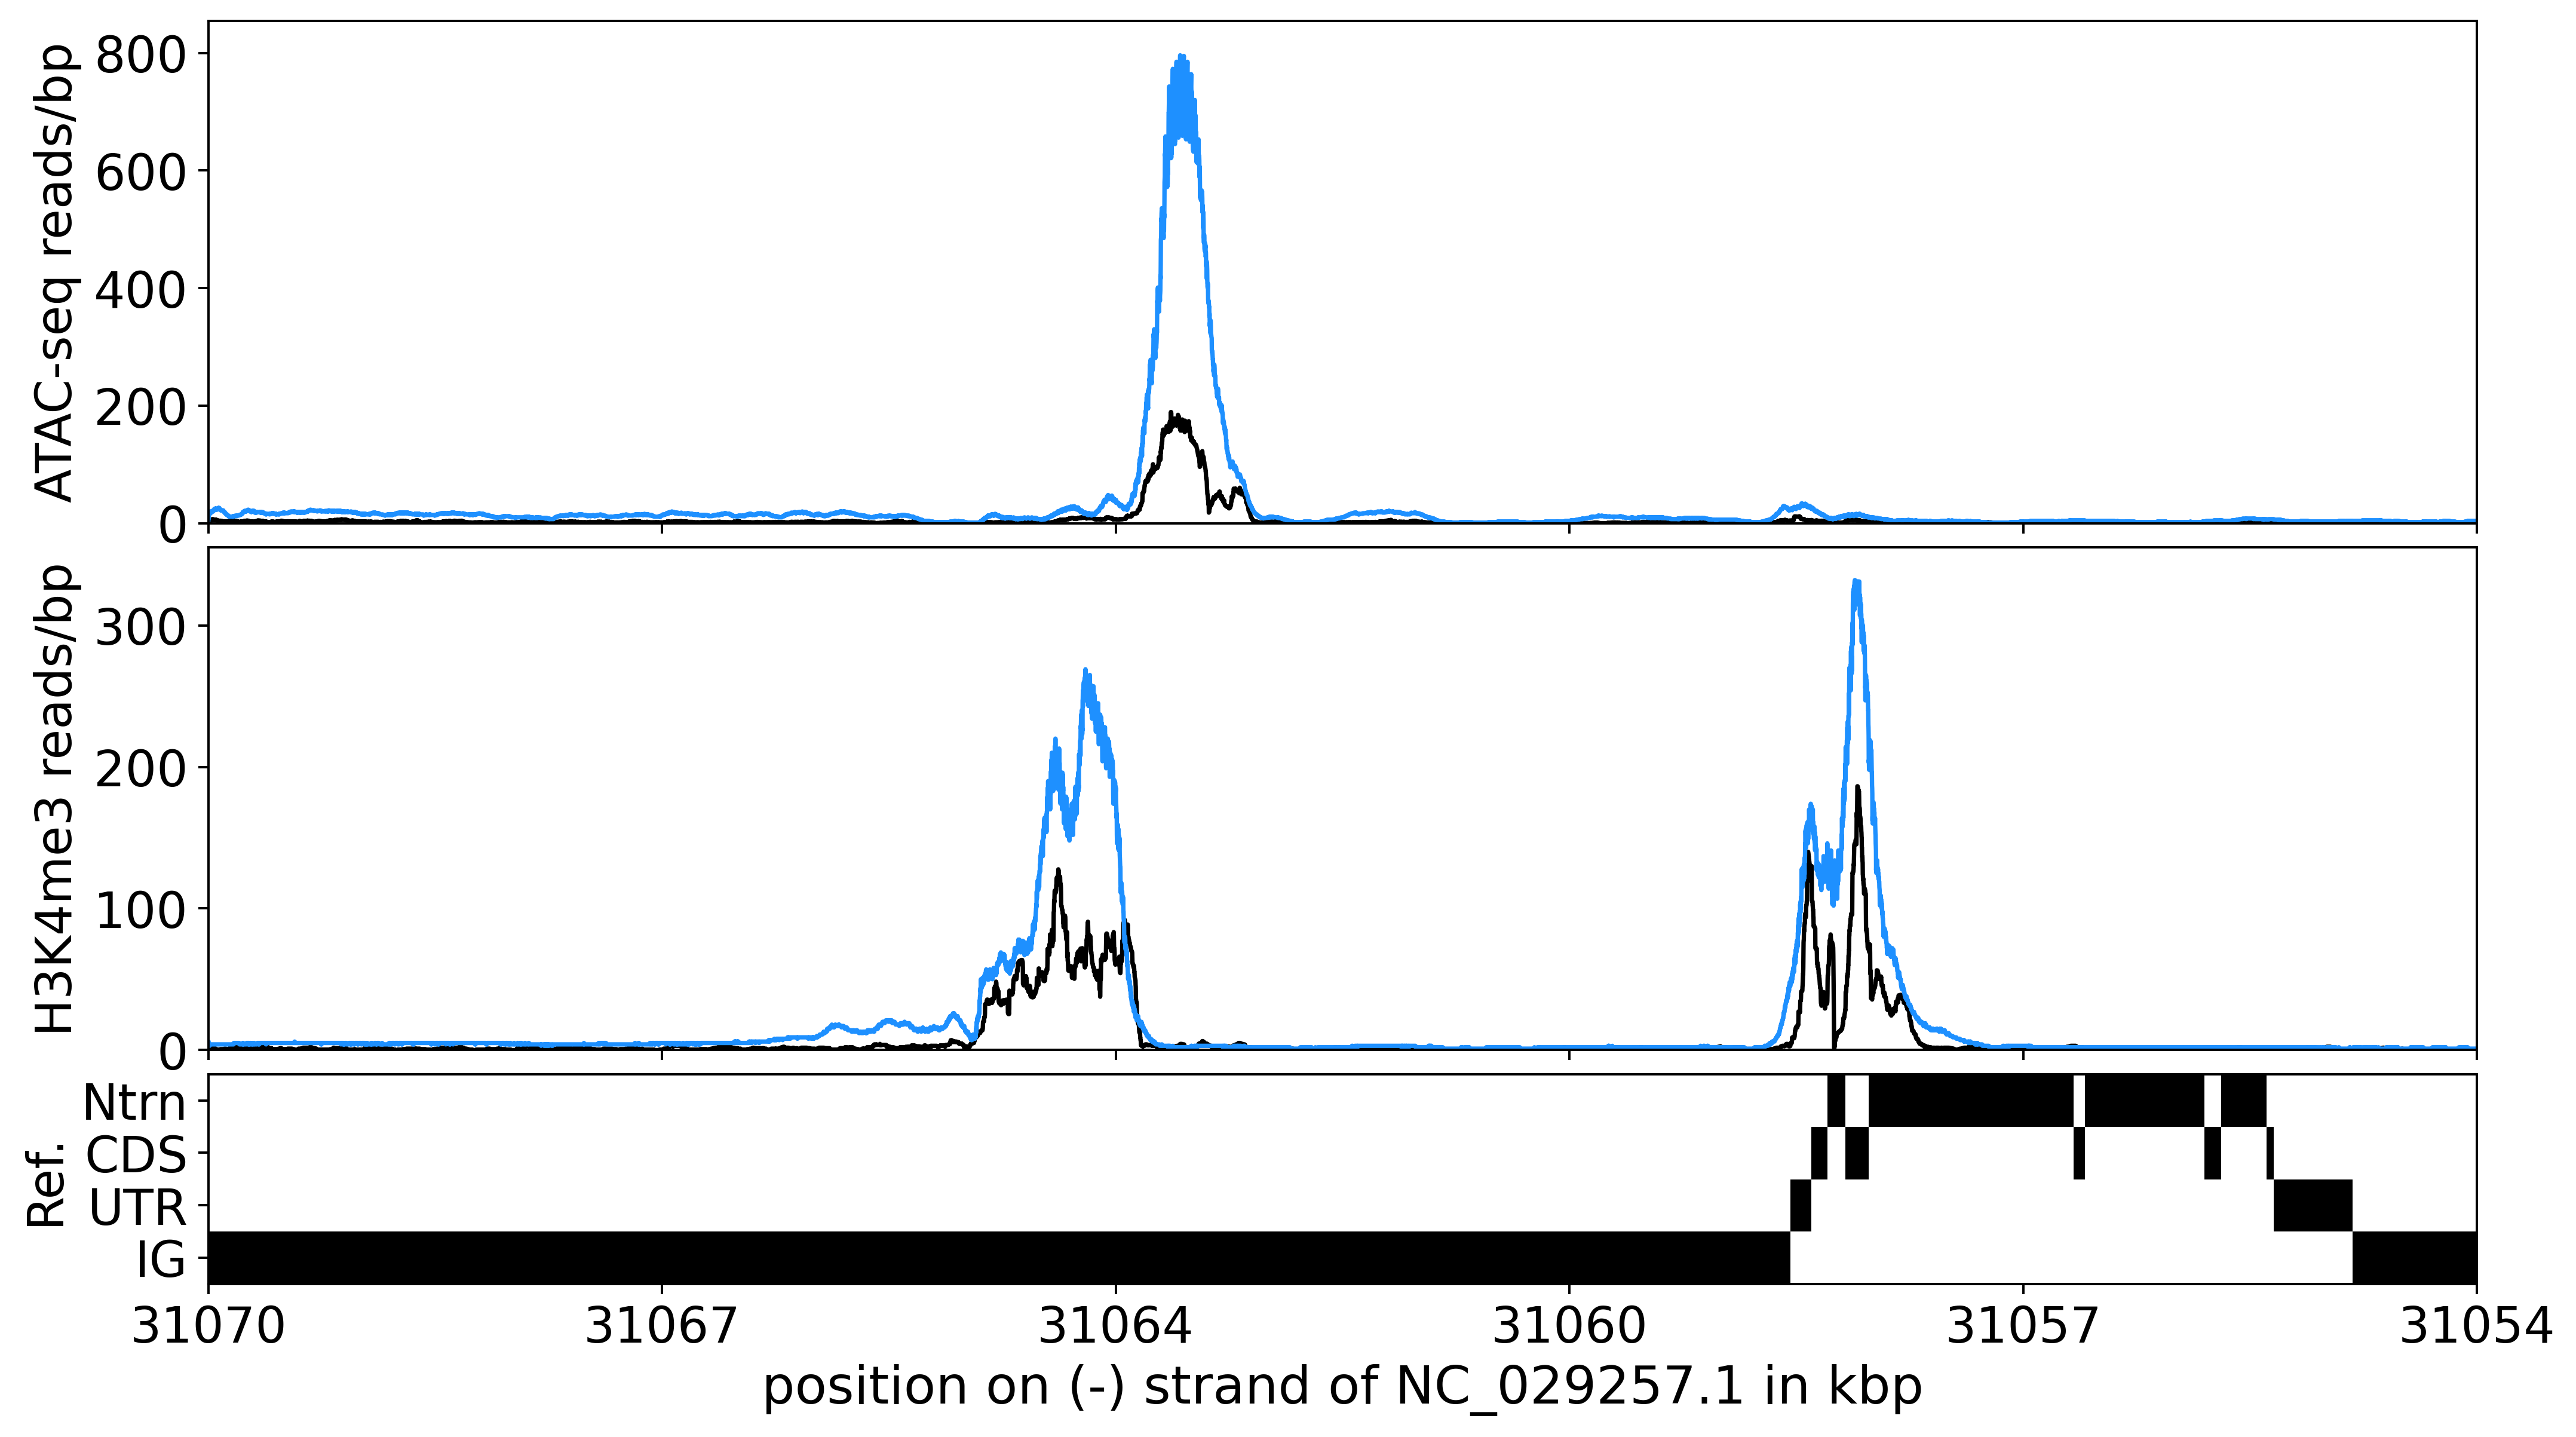

In [21]:
plot_selected(5957, f, g, ylim=[[0, 855], [0, 355]], start=0, end=16700, dpi=350)

1
b'NC_029256.1' [21384 42768]
atacseq
h3k4me3


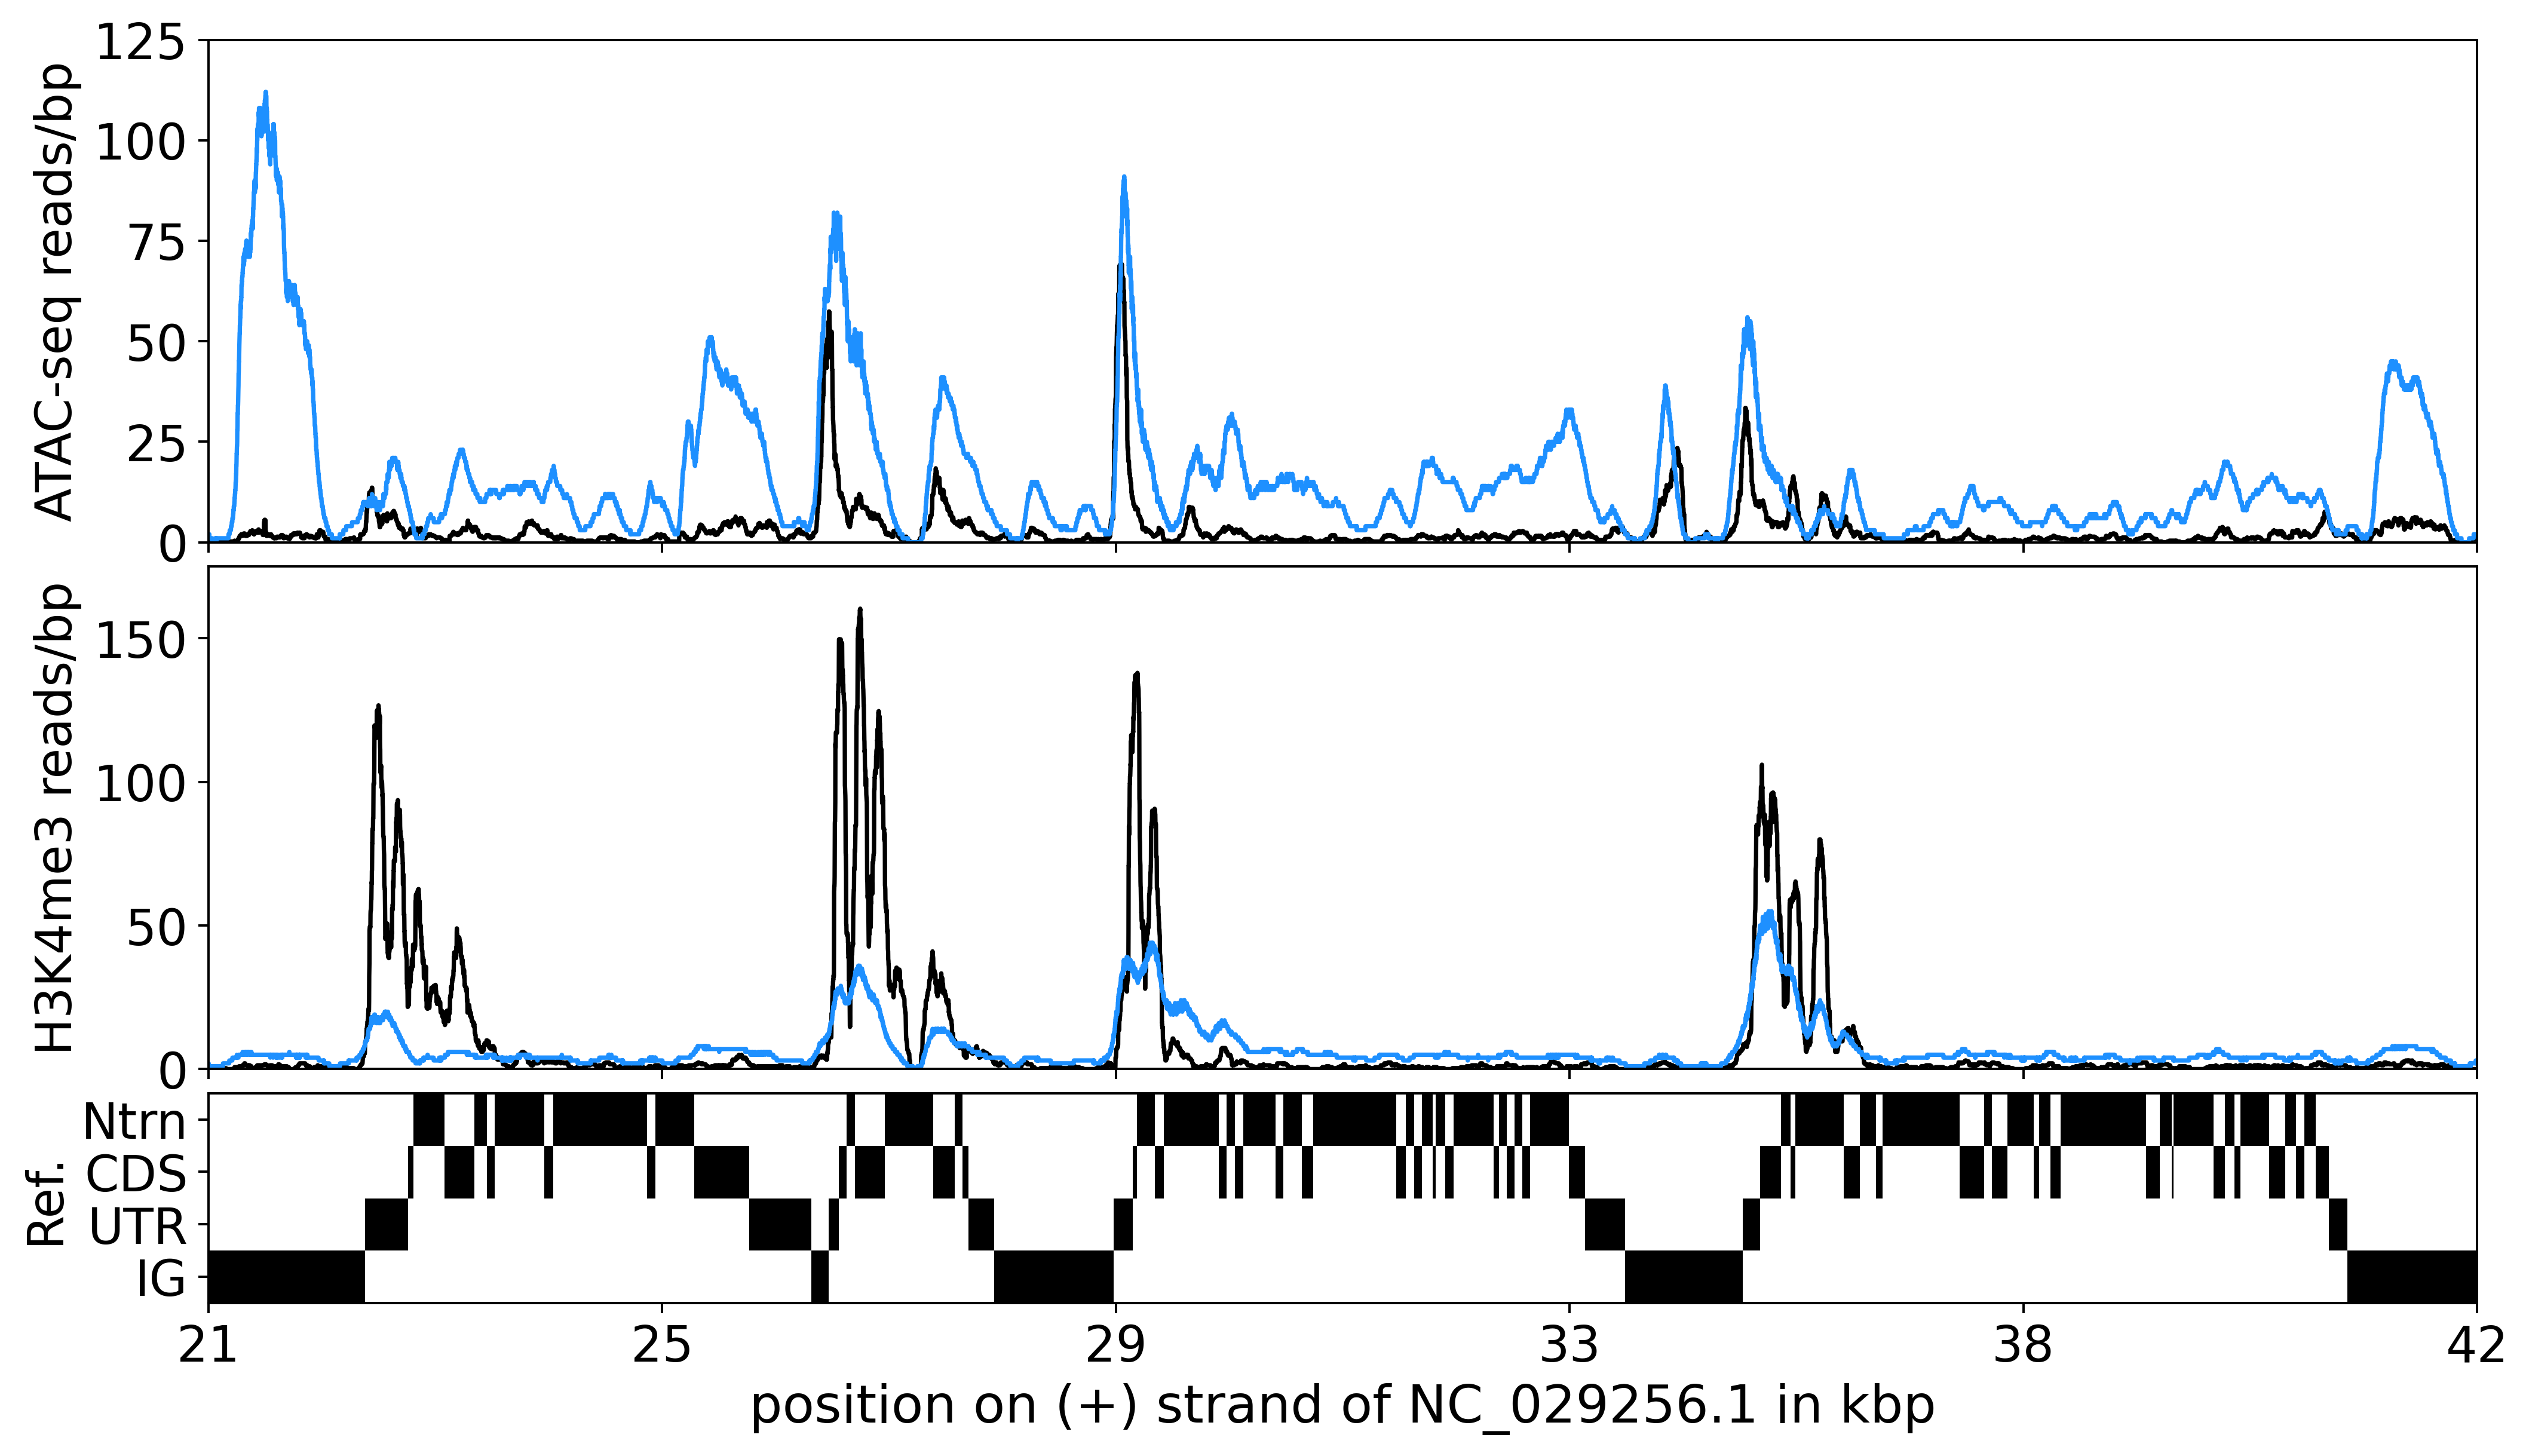

In [22]:
plot_selected(1, f, g, ylim=[[0, 125], [0, 175]], start=0, end=21000, dpi=350)